In [1]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier

In [2]:
param_dist = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'min_child_samples': [10, 20, 30]
}

In [3]:
pd.set_option('display.max_rows', None)

In [4]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.preprocessing import label_binarize

def train_phase(phase_path, param_dist, n_iter=10, random_state=42, sample=False):
    best_model = None
    best_score = 0
    all_metrics = []
    best_params = None

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")
        
        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        
        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train.columns)

        # Hyperparameter tuning on fold 1
        if fold == 1:
            clf = LGBMClassifier(random_state=random_state)
            search = RandomizedSearchCV(
                clf,
                param_distributions=param_dist,
                n_iter=n_iter,
                cv=3,
                n_jobs=-1,
                verbose=1,
                scoring='f1_macro'
            )
            search.fit(X_train_scaled, y_train)
            best_params = search.best_params_
            print(f"[Fold 1] Best Parameters Found: {best_params}")

        model = LGBMClassifier(**best_params, random_state=random_state)
        model.fit(X_train_scaled, y_train)

        y_pred = model.predict(X_val_scaled)
        y_proba = model.predict_proba(X_val_scaled)

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')

        # Compute multiclass AUC
        classes = model.classes_
        y_val_bin = label_binarize(y_val, classes=classes)
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val, y_pred))

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # Plot ROC Curve per class
        plt.figure(figsize=(8, 6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {cls}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Print averages
    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    # Feature importance
    feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    print("\nTop Feature Importances:")
    print(feature_importances.head(10))

    return best_model, best_scaler, best_fold, all_metrics



=== Training Phase 1 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 7237, number of used features: 32
[LightGBM] [Info] Start training from score -0.418749
[LightGBM] [Info] Start training from score -1.504216
[LightGBM] [Info] Start training from score -2.353173
[LightGBM] [Info] Start training from score -3.830716
[LightGBM] [Info] Start training from score -5.751468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

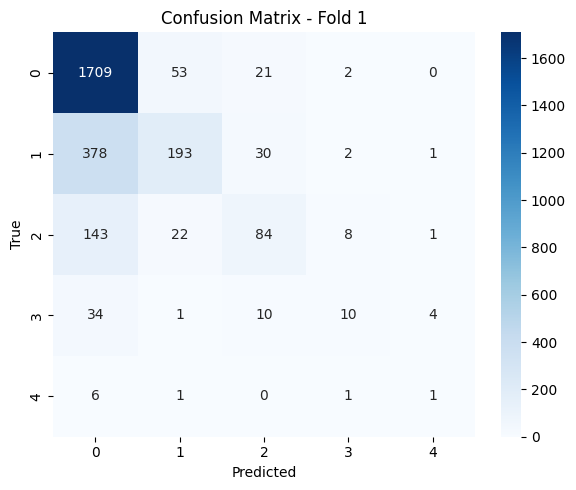

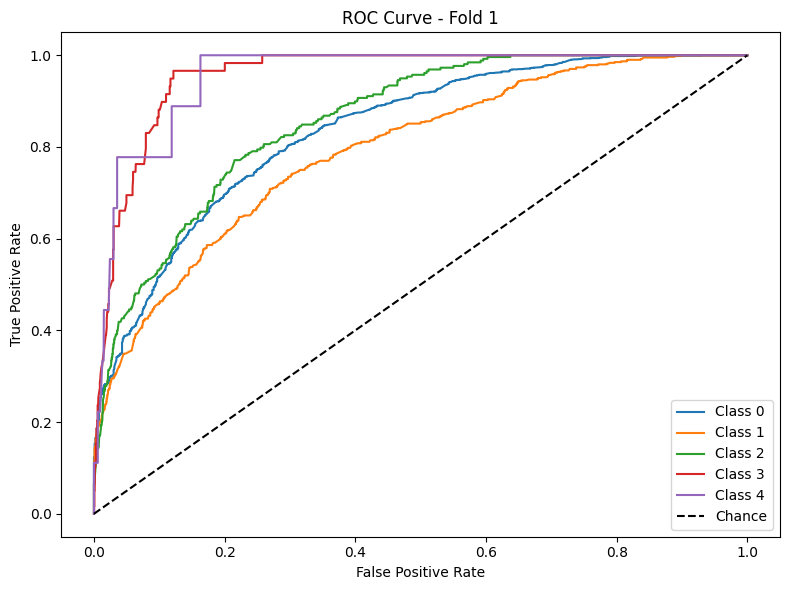

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2786
[LightGBM] [Info] Number of data points in the train set: 10857, number of used features: 32
[LightGBM] [Info] Start training from score -0.418957
[LightGBM] [Info] Start training from score -1.503939
[LightGBM] [Info] Start training from score -2.353311
[LightGBM] [Info] Start training from score -3.828734
[LightGBM] [Info] Start training from score -5.737217

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.95      0.84      1786
           1       0.65      0.29      0.40       603
           2       0.62      0.33      0.43       258
           3       0.35      0.19      0.24        59
           4       0.50      0.38      0.43         8

    accuracy       

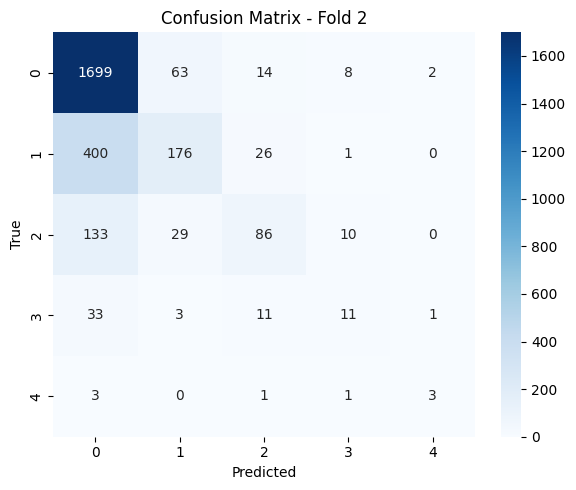

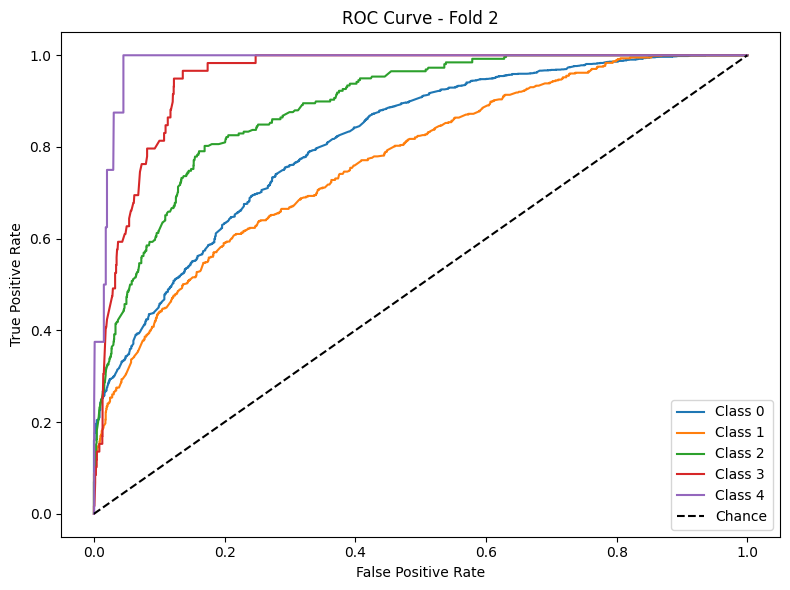

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2762
[LightGBM] [Info] Number of data points in the train set: 10857, number of used features: 32
[LightGBM] [Info] Start training from score -0.418957
[LightGBM] [Info] Start training from score -1.503939
[LightGBM] [Info] Start training from score -2.353311
[LightGBM] [Info] Start training from score -3.828734
[LightGBM] [Info] Start training from score -5.737217

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.94      0.84      1786
           1       0.68      0.32      0.43       603
           2       0.59      0.33      0.42       258
           3       0.45      0.25      0.33        59
           4       0.30      0.38      0.33         8

    accuracy       

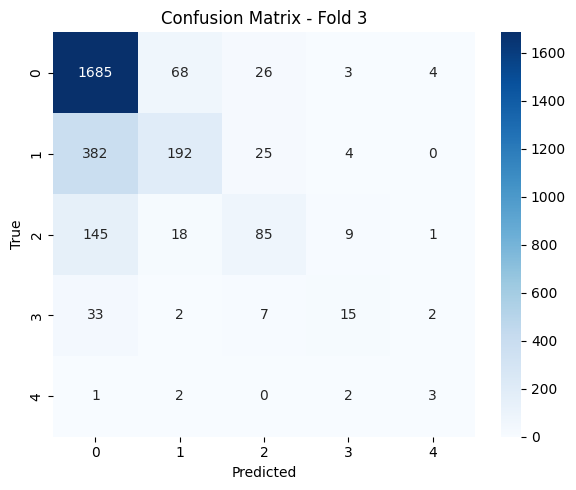

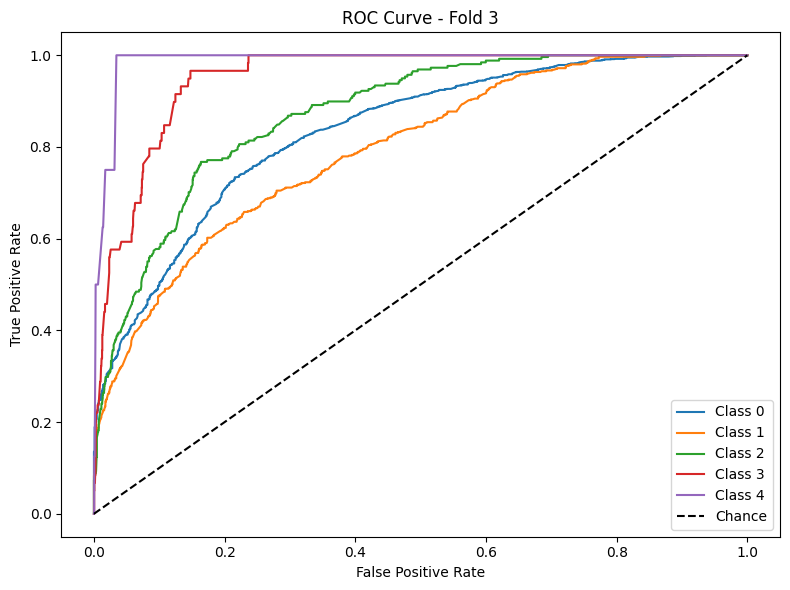

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2744
[LightGBM] [Info] Number of data points in the train set: 10857, number of used features: 32
[LightGBM] [Info] Start training from score -0.418817
[LightGBM] [Info] Start training from score -1.503939
[LightGBM] [Info] Start training from score -2.353311
[LightGBM] [Info] Start training from score -3.828734
[LightGBM] [Info] Start training from score -5.766205

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.96      0.84      1785
           1       0.72      0.33      0.45       603
           2       0.64      0.34      0.44       258
           3       0.29      0.14      0.18        59
           4       0.40      0.22      0.29         9

    accuracy                           0.74      2714
   macro avg       0.56      

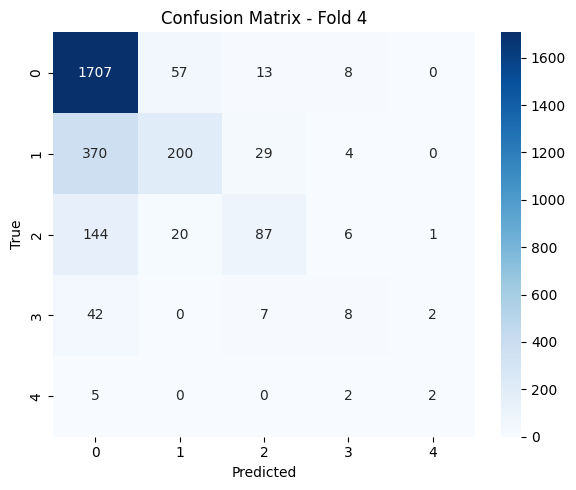

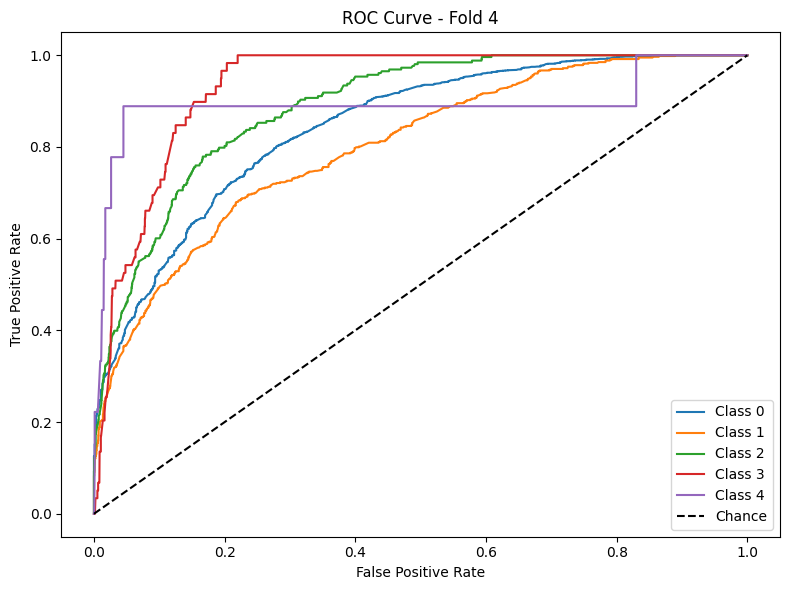

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2767
[LightGBM] [Info] Number of data points in the train set: 10857, number of used features: 32
[LightGBM] [Info] Start training from score -0.418817
[LightGBM] [Info] Start training from score -1.503939
[LightGBM] [Info] Start training from score -2.353311
[LightGBM] [Info] Start training from score -3.828734
[LightGBM] [Info] Start training from score -5.766205

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.96      0.84      1785
           1       0.69      0.30      0.42       603
           2       0.57      0.30      0.39       258
           3       0.53      0.17      0.26        59
           4       0.50      0.33      0.40         9

    accuracy       

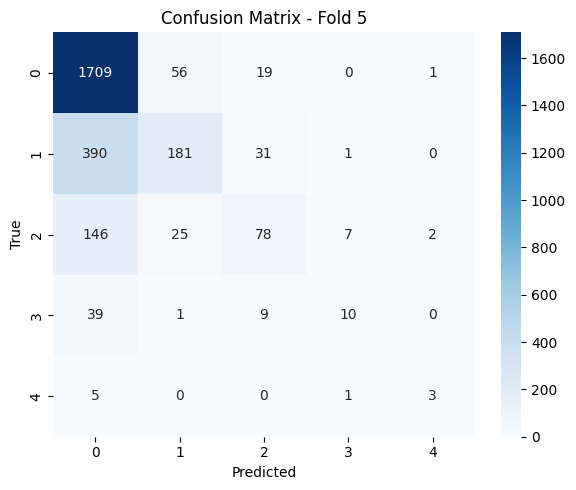

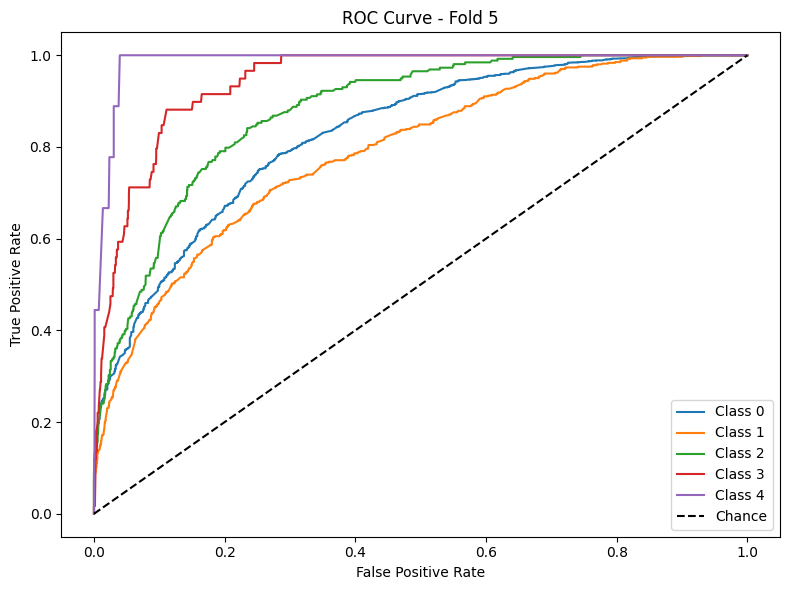


Average Accuracy: 0.7322
Average F1 Macro: 0.4515
Average AUC: 0.8813

Top Feature Importances:
remaining_time                 3299
total_words_phase1             1567
school                         1146
encoded_field_sum               787
video                           672
exercise_count                  672
video_count                     617
duration_days                   568
user_month                      567
entropy_time_comment_phase1     522
dtype: int32

=== Training Phase 2 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

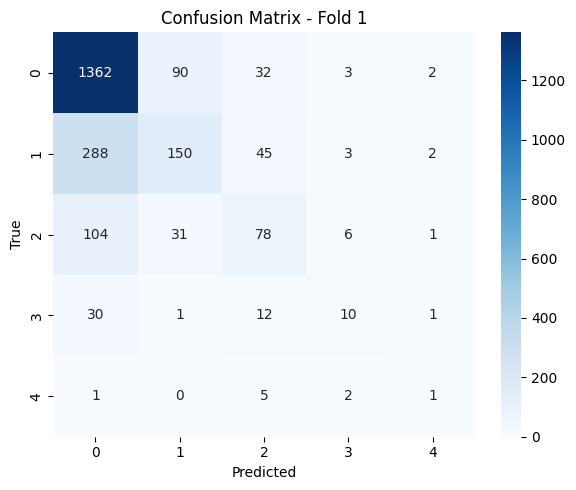

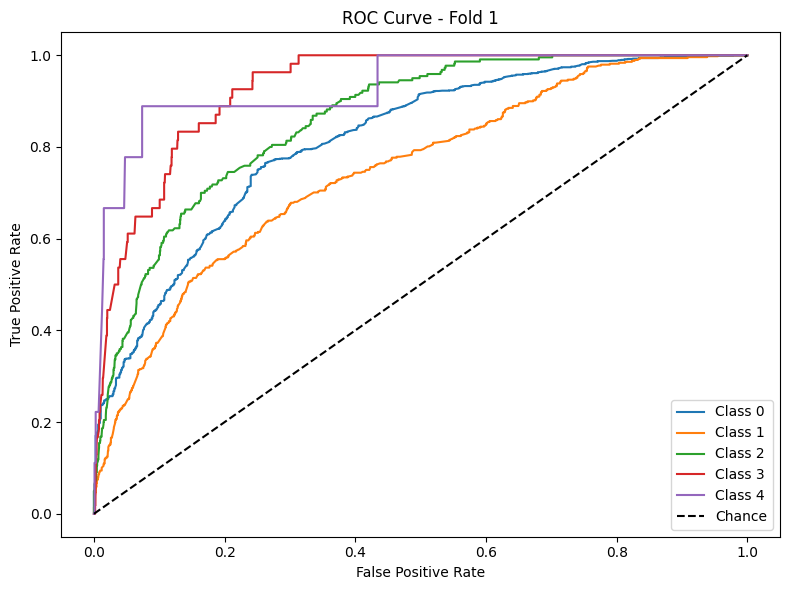

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2701
[LightGBM] [Info] Number of data points in the train set: 9037, number of used features: 48
[LightGBM] [Info] Start training from score -0.416760
[LightGBM] [Info] Start training from score -1.531449
[LightGBM] [Info] Start training from score -2.332576
[LightGBM] [Info] Start training from score -3.733804
[LightGBM] [Info] Start training from score -5.612575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

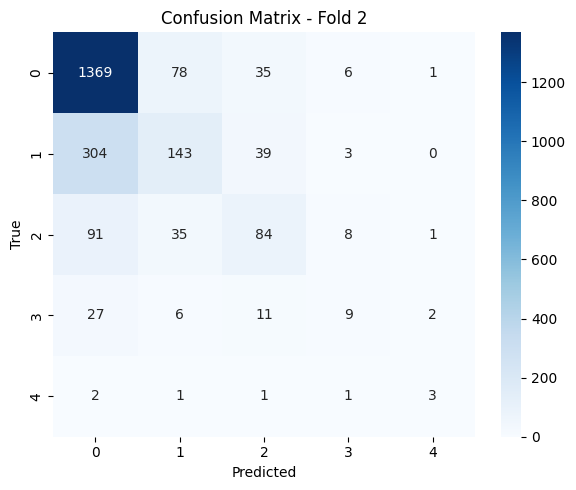

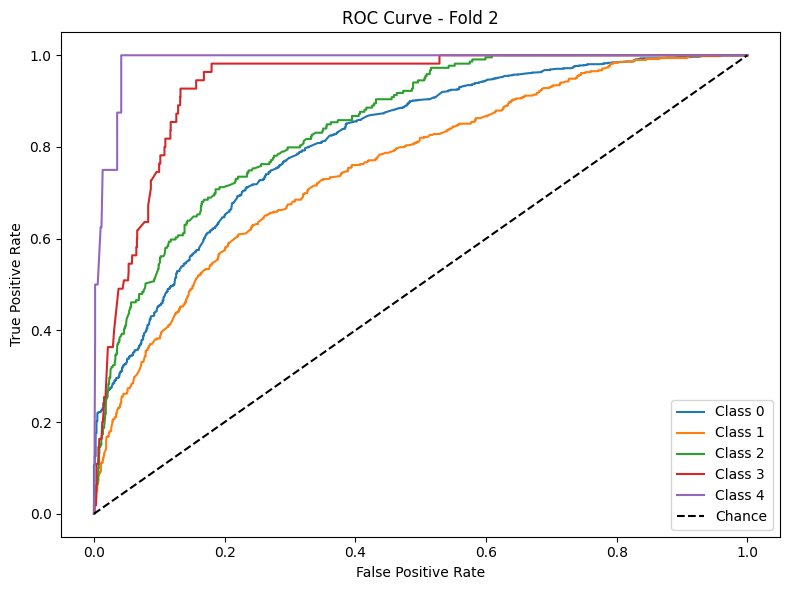

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 48
[LightGBM] [Info] Start training from score -0.416871
[LightGBM] [Info] Start training from score -1.531559
[LightGBM] [Info] Start training from score -2.332686
[LightGBM] [Info] Start training from score -3.729296
[LightGBM] [Info] Start training from score -5.612686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

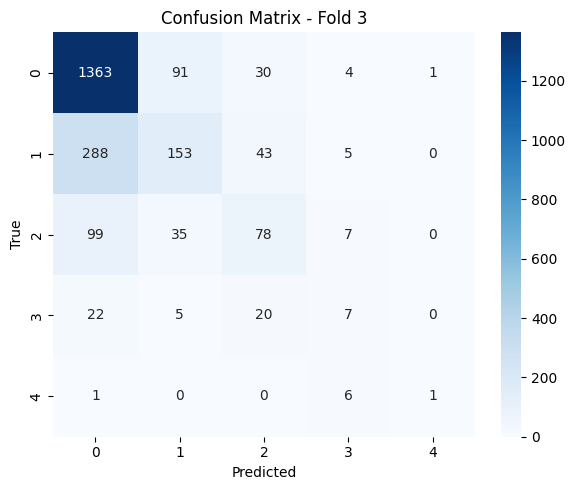

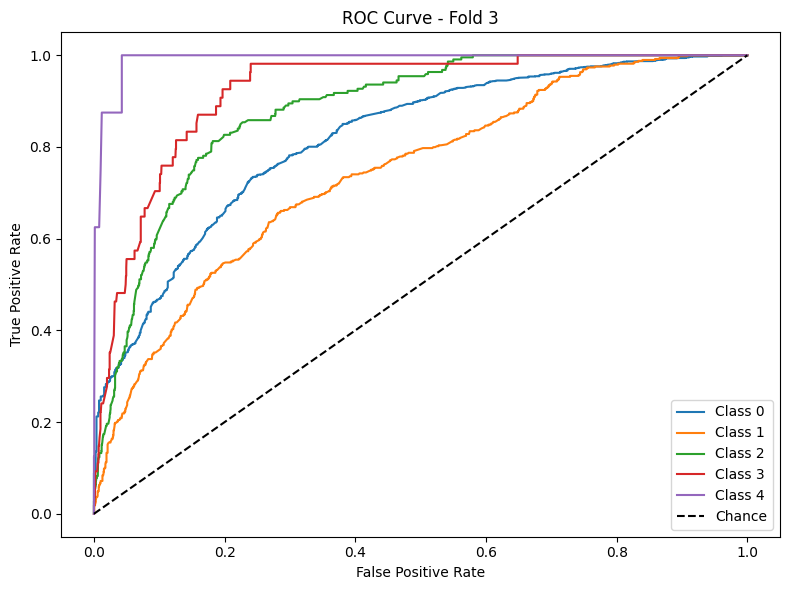

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2678
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 48
[LightGBM] [Info] Start training from score -0.416871
[LightGBM] [Info] Start training from score -1.531559
[LightGBM] [Info] Start training from score -2.332686
[LightGBM] [Info] Start training from score -3.729296
[LightGBM] [Info] Start training from score -5.612686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

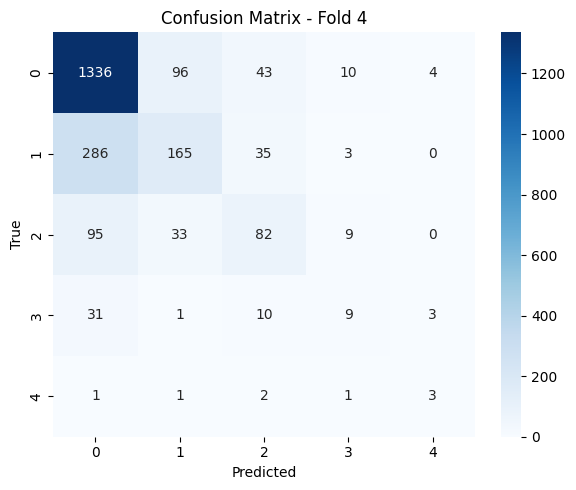

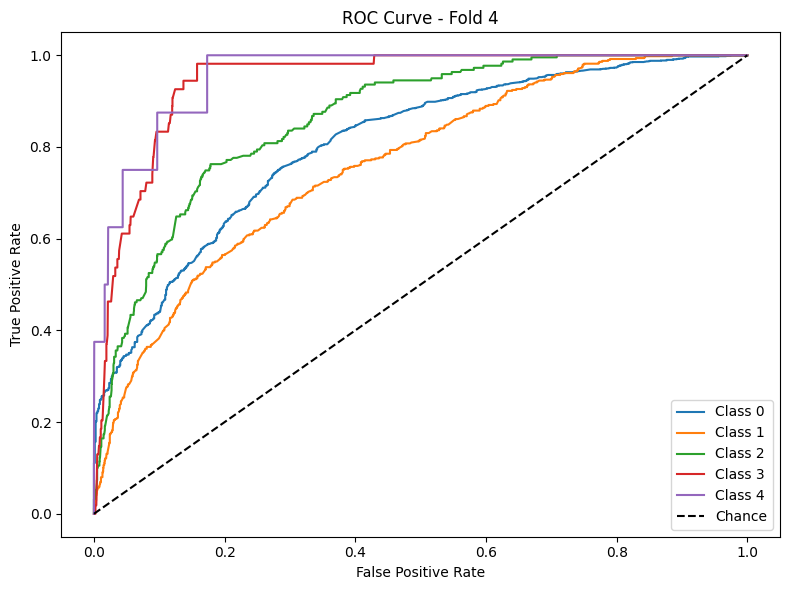

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2613
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 48
[LightGBM] [Info] Start training from score -0.417039
[LightGBM] [Info] Start training from score -1.531048
[LightGBM] [Info] Start training from score -2.332686
[LightGBM] [Info] Start training from score -3.729296
[LightGBM] [Info] Start training from score -5.612686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

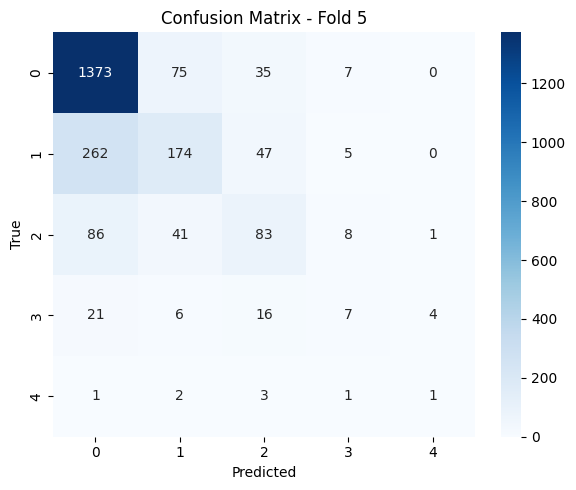

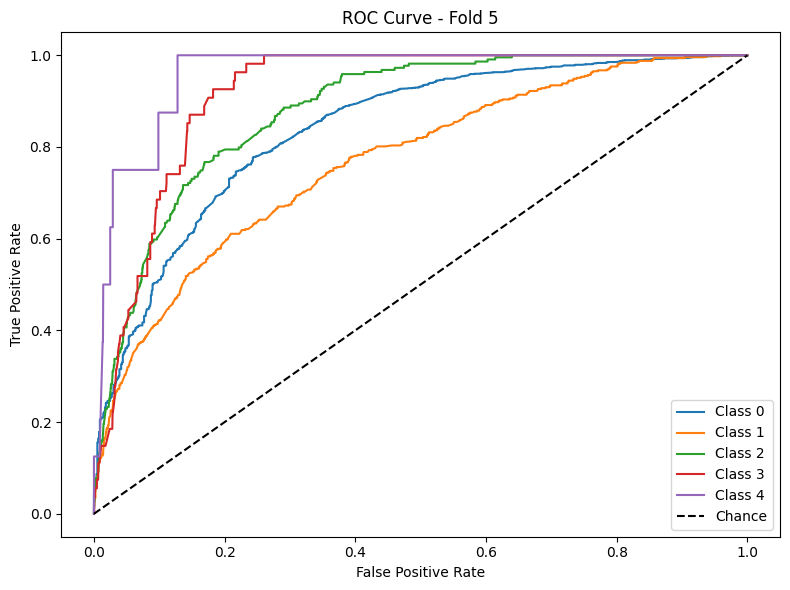


Average Accuracy: 0.7120
Average F1 Macro: 0.4199
Average AUC: 0.8669

Top Feature Importances:
remaining_time        7489
total_words_phase1    3582
school                2556
total_words_phase2    1429
encoded_field_sum     1227
video_count           1179
exercise_count        1137
user_month             988
total_neutral1         979
duration_days          855
dtype: int32

=== Training Phase 3 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

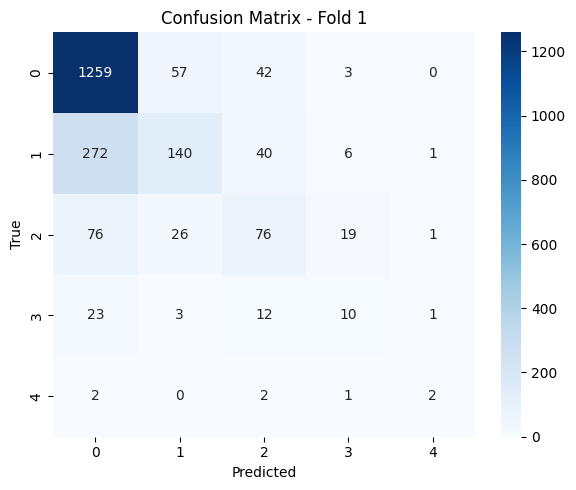

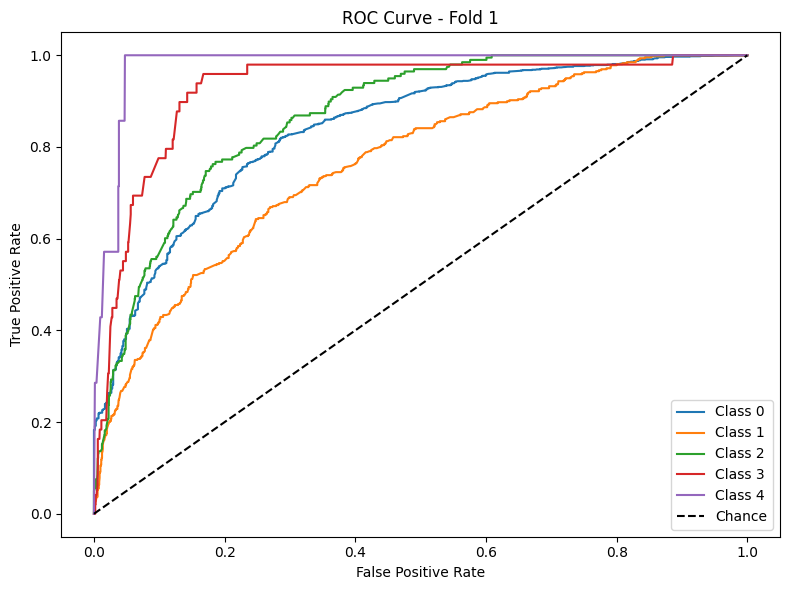

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3036
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 62
[LightGBM] [Info] Start training from score -0.421690
[LightGBM] [Info] Start training from score -1.507519
[LightGBM] [Info] Start training from score -2.350110
[LightGBM] [Info] Start training from score -3.735141
[LightGBM] [Info] Start training from score -5.691204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.83      1360
           1       0.59      0.36      0.45       459
           2       0.49      0.43

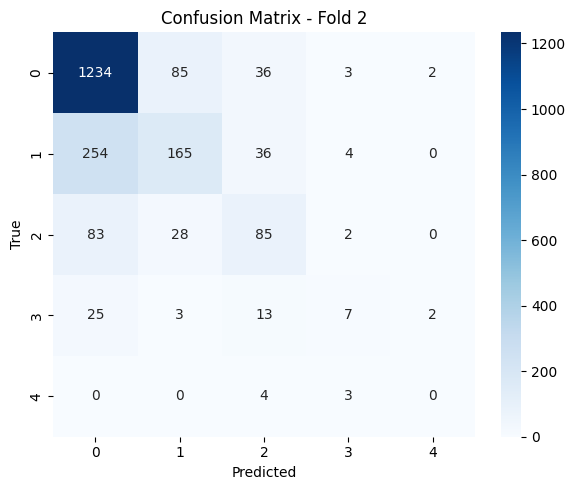

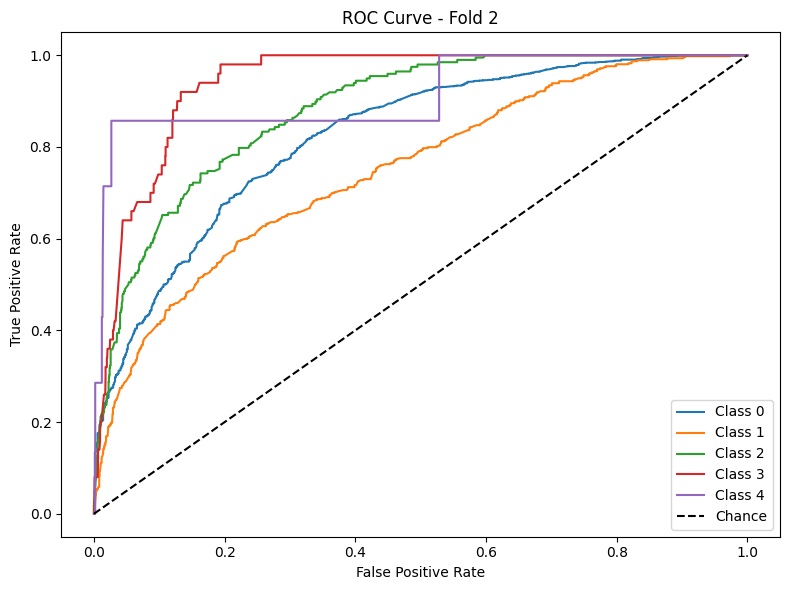

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2982
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 62
[LightGBM] [Info] Start training from score -0.421690
[LightGBM] [Info] Start training from score -1.507519
[LightGBM] [Info] Start training from score -2.350110
[LightGBM] [Info] Start training from score -3.735141
[LightGBM] [Info] Start training from score -5.691204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.90      0.84      1360
           1       0.52      0.33      0.40       459
           2       0.42      0.41

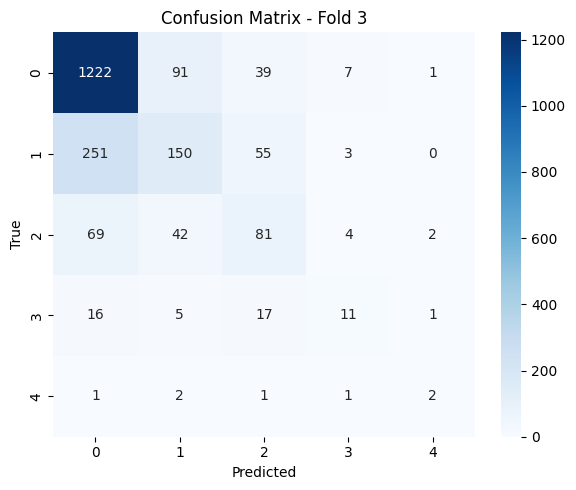

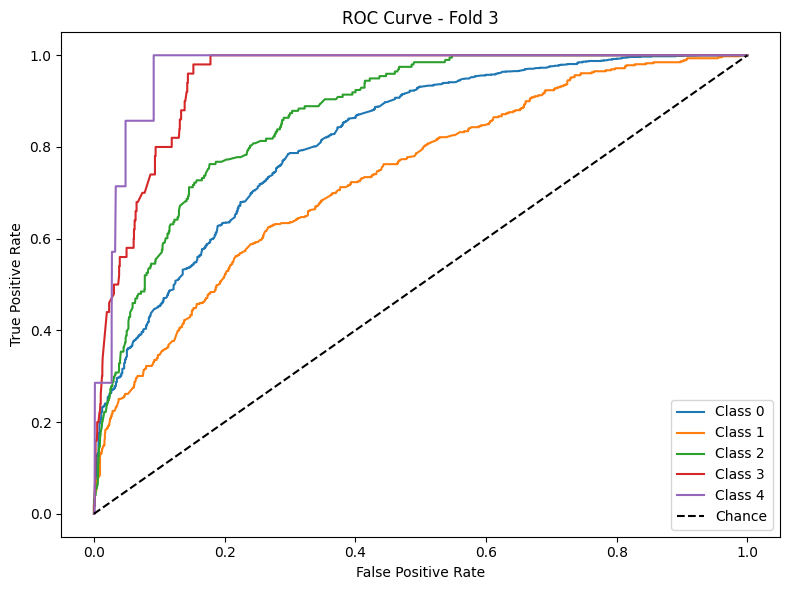

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 62
[LightGBM] [Info] Start training from score -0.421690
[LightGBM] [Info] Start training from score -1.507519
[LightGBM] [Info] Start training from score -2.350110
[LightGBM] [Info] Start training from score -3.735141
[LightGBM] [Info] Start training from score -5.691204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.90      0.82      1360
           1       0.51      0.31      0.39       459
           2       0.50      0.35

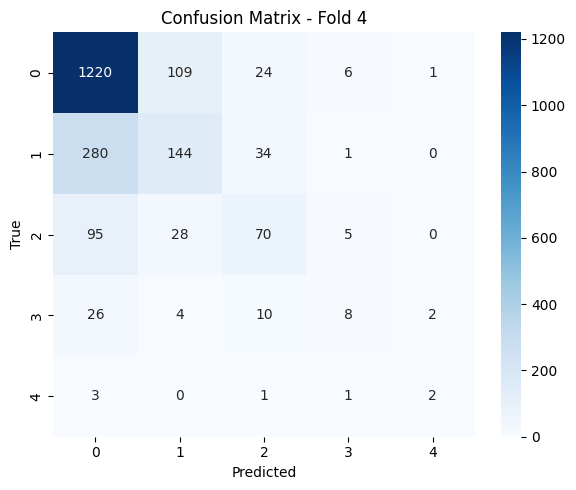

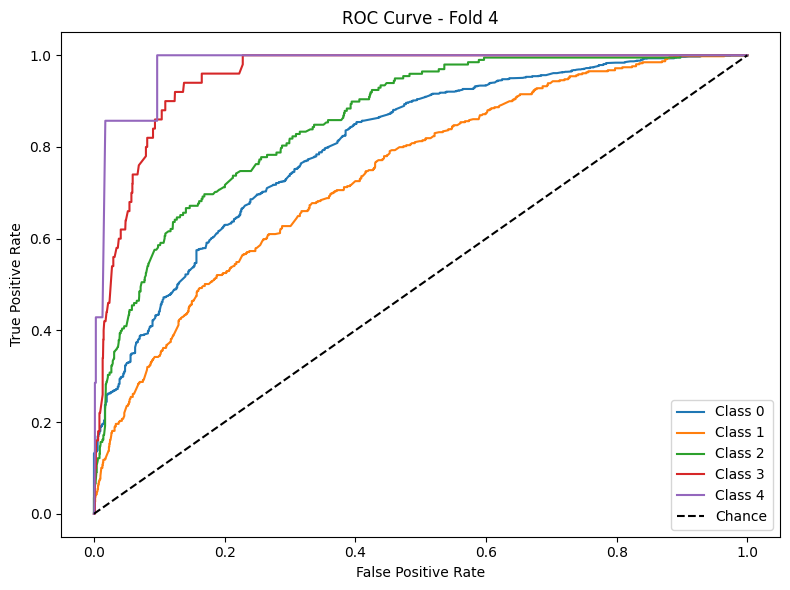

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2951
[LightGBM] [Info] Number of data points in the train set: 8296, number of used features: 61
[LightGBM] [Info] Start training from score -0.421811
[LightGBM] [Info] Start training from score -1.508184
[LightGBM] [Info] Start training from score -2.348967
[LightGBM] [Info] Start training from score -3.730224
[LightGBM] [Info] Start training from score -5.691324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.90      0.83      1360
           1       0.54      0.33      0.41       460
           2       0.48      0.39

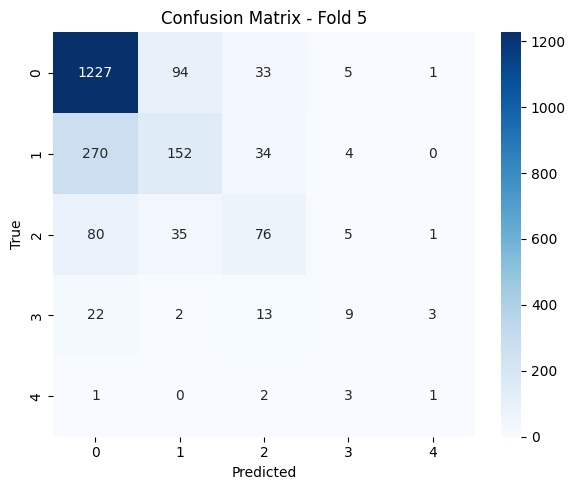

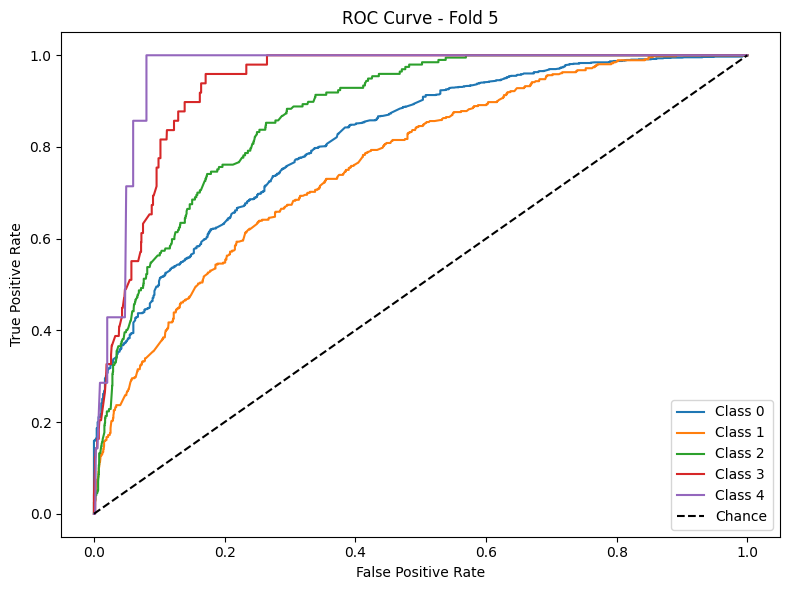


Average Accuracy: 0.7091
Average F1 Macro: 0.4260
Average AUC: 0.8685

Top Feature Importances:
remaining_time        11013
total_words_phase1     4266
school                 4068
total_words_phase3     2449
encoded_field_sum      2413
video_count            2367
exercise_count         2103
total_words_phase2     2059
duration_days          1701
user_month             1551
dtype: int32

=== Training Phase 4 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

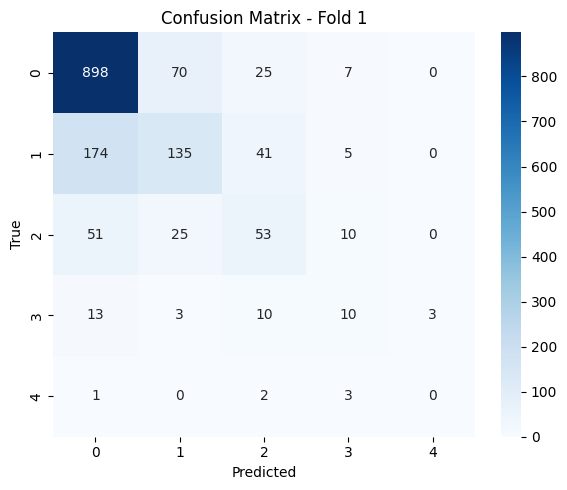

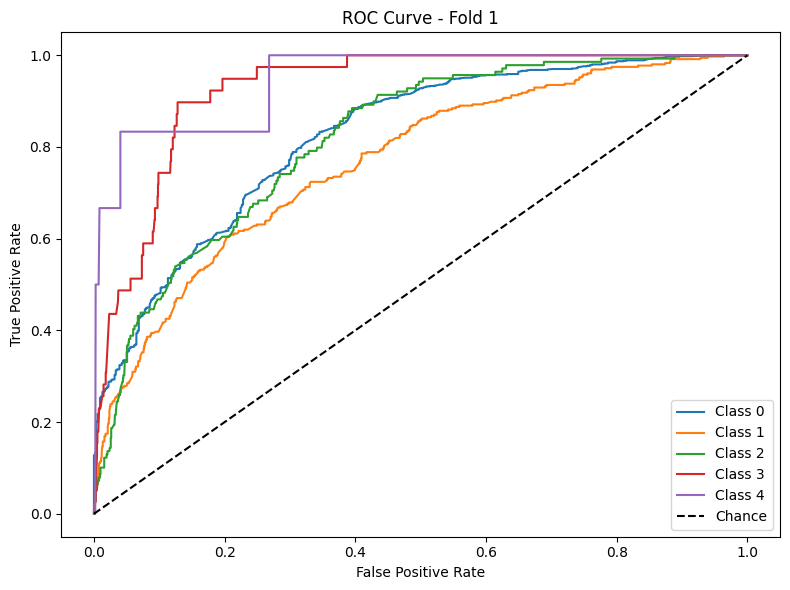

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3947
[LightGBM] [Info] Number of data points in the train set: 6154, number of used features: 78
[LightGBM] [Info] Start training from score -0.431558
[LightGBM] [Info] Start training from score -1.465038
[LightGBM] [Info] Start training from score -2.407693
[LightGBM] [Info] Start training from score -3.668612
[LightGBM] [Info] Start training from score -5.546804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

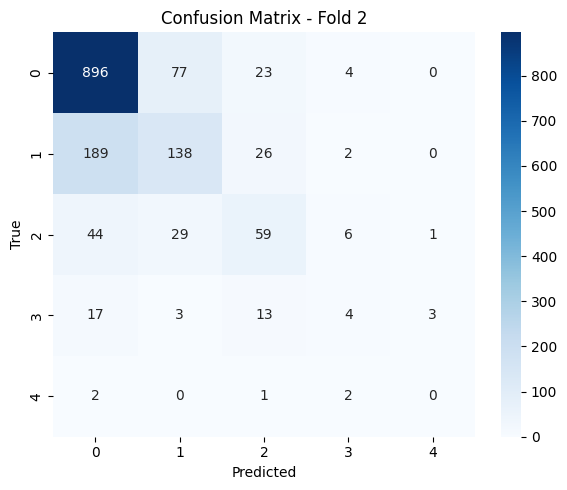

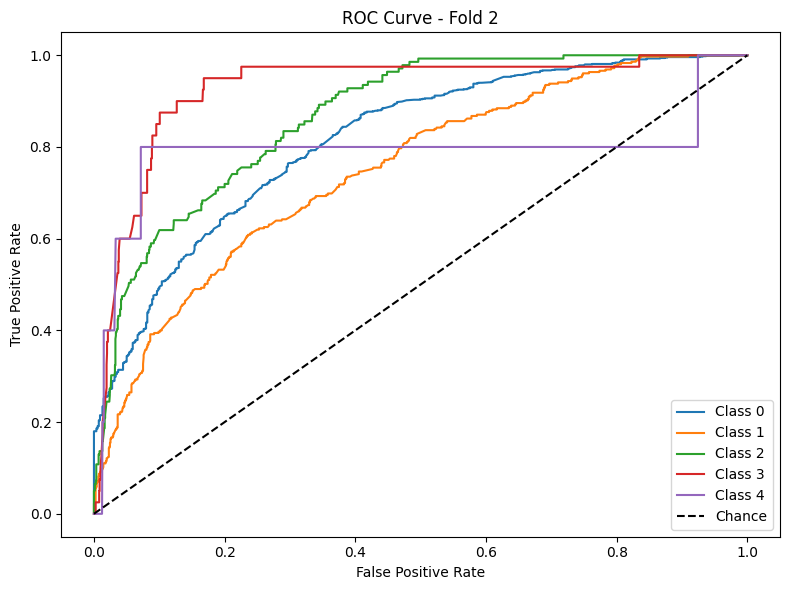

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3979
[LightGBM] [Info] Number of data points in the train set: 6154, number of used features: 78
[LightGBM] [Info] Start training from score -0.431308
[LightGBM] [Info] Start training from score -1.465038
[LightGBM] [Info] Start training from score -2.407693
[LightGBM] [Info] Start training from score -3.668612
[LightGBM] [Info] Start training from score -5.589363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

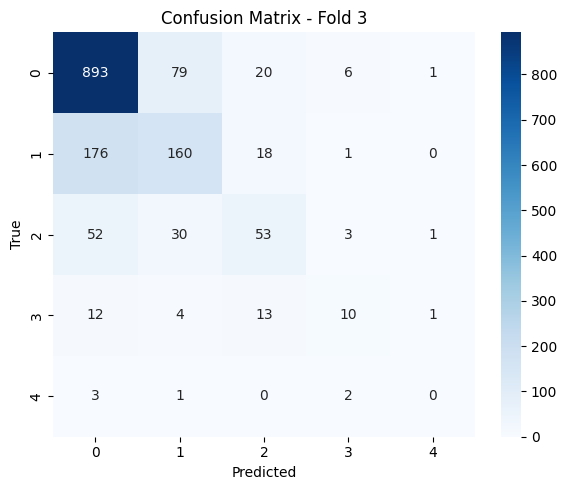

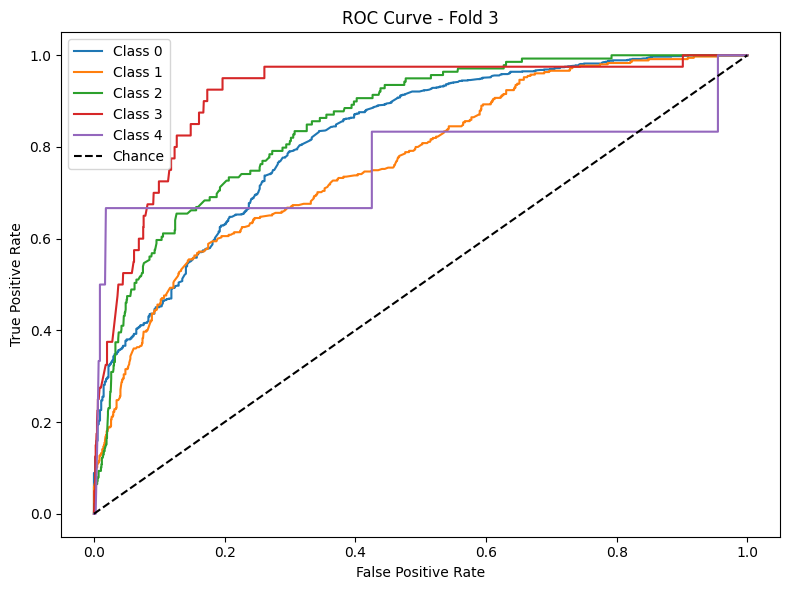

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3930
[LightGBM] [Info] Number of data points in the train set: 6155, number of used features: 78
[LightGBM] [Info] Start training from score -0.431471
[LightGBM] [Info] Start training from score -1.465904
[LightGBM] [Info] Start training from score -2.406052
[LightGBM] [Info] Start training from score -3.662425
[LightGBM] [Info] Start training from score -5.589526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

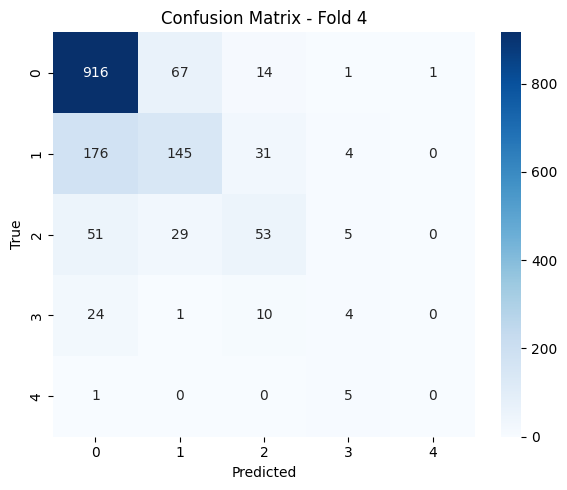

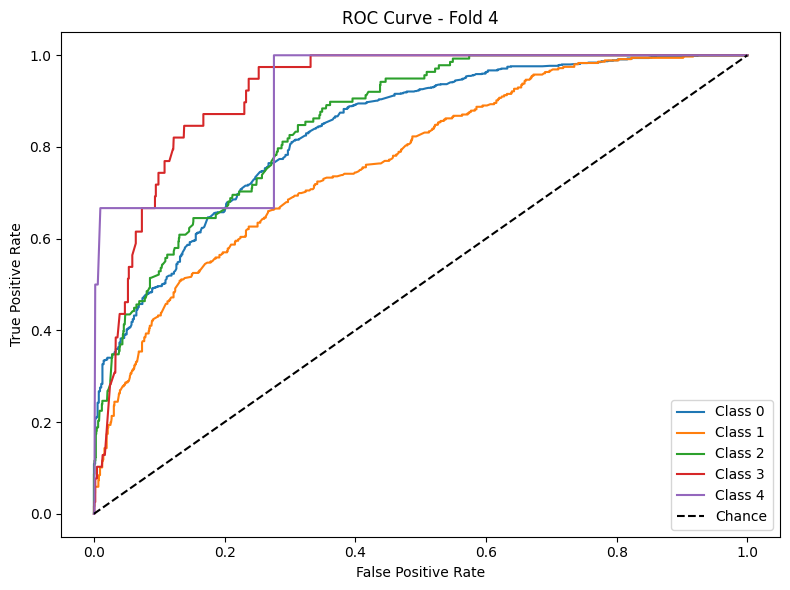

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3989
[LightGBM] [Info] Number of data points in the train set: 6155, number of used features: 79
[LightGBM] [Info] Start training from score -0.431471
[LightGBM] [Info] Start training from score -1.465904
[LightGBM] [Info] Start training from score -2.406052
[LightGBM] [Info] Start training from score -3.662425
[LightGBM] [Info] Start training from score -5.589526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

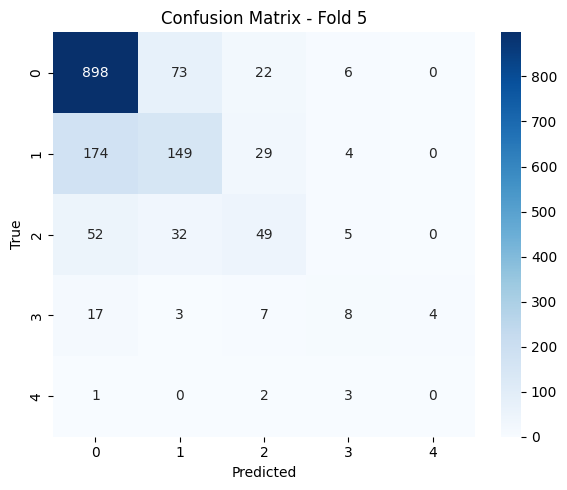

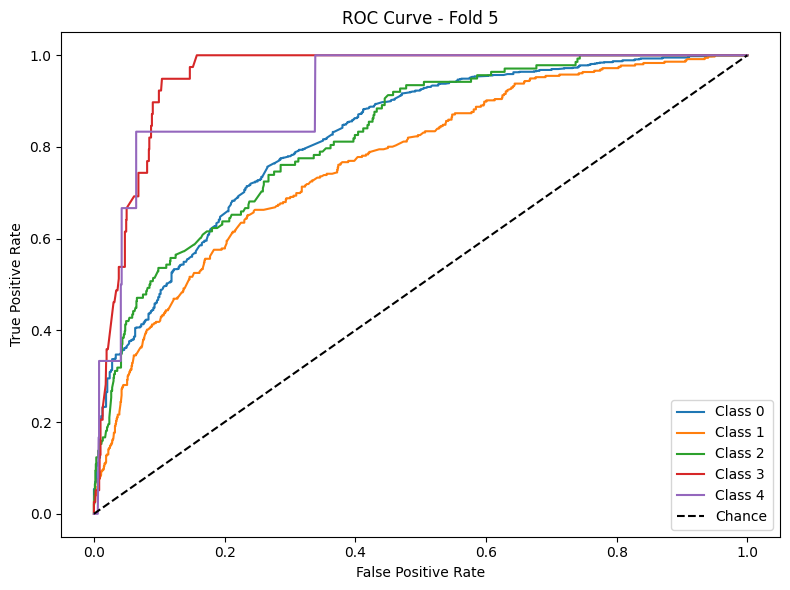


Average Accuracy: 0.7190
Average F1 Macro: 0.3927
Average AUC: 0.8448

Top Feature Importances:
remaining_time        10232
total_words_phase1     3930
school                 3771
total_words_phase4     2946
encoded_field_sum      1635
video_count            1407
user_month             1334
total_neutral1         1267
exercise_count         1151
duration_days          1147
dtype: int32


In [5]:
phase_paths = [f"/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, param_dist, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics


## Predict on Test Data

In [6]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

def predict_on_test(test_file_path, model_file, scaler_file, school_mapping_file):
    # Load model, scaler, and mapping
    model = joblib.load(model_file)
    scaler = joblib.load(scaler_file)
    mapping = joblib.load(school_mapping_file)

    # Load and preprocess test data
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded']
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    # Apply school mapping
    if 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    # Scale features
    X_test_scaled = scaler.transform(X_test)

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score
    classes = model.classes_
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       568
           1       0.49      0.29      0.36        63
           2       0.37      0.23      0.29        43
           3       0.00      0.00      0.00        15
           4       1.00      0.22      0.36         9

    accuracy                           0.83       698
   macro avg       0.55      0.34      0.39       698
weighted avg       0.79      0.83      0.80       698



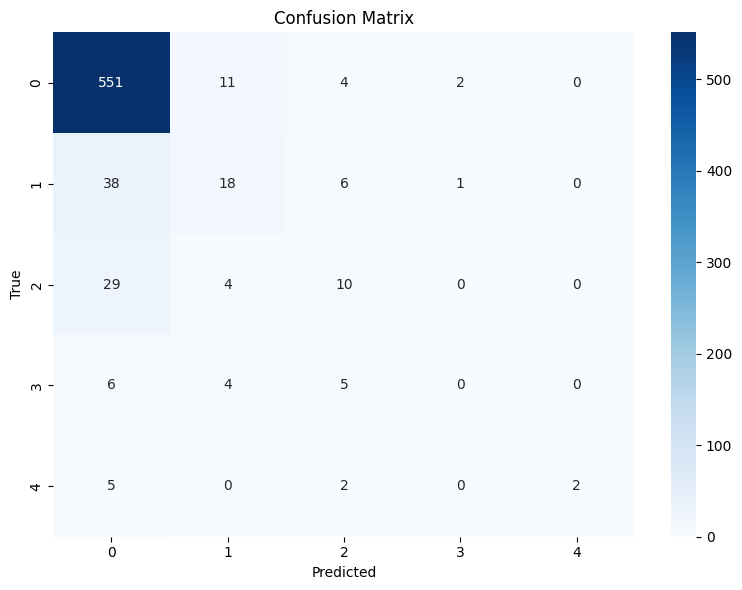


Test AUC (macro-average, OVR): 0.8686


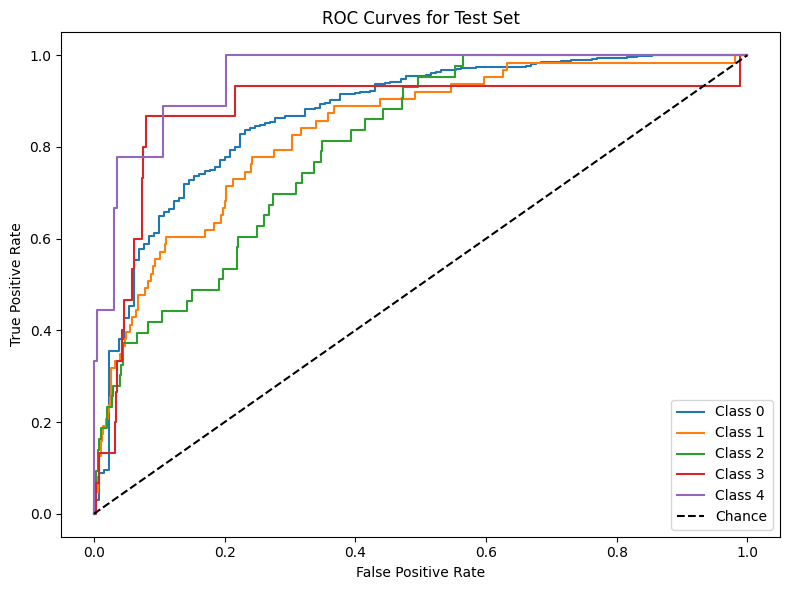


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       544
           1       0.27      0.12      0.16        59
           2       0.26      0.24      0.25        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.81       668
   macro avg       0.28      0.26      0.26       668
weighted avg       0.75      0.81      0.77       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


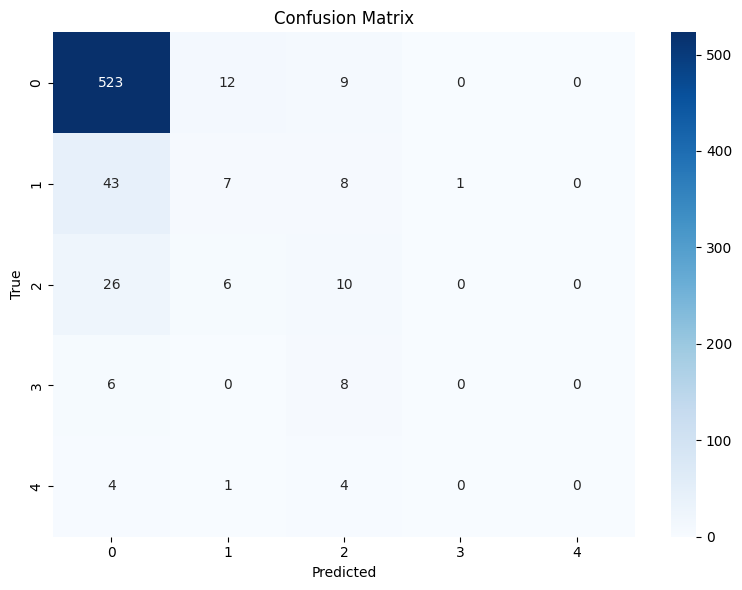


Test AUC (macro-average, OVR): 0.8542


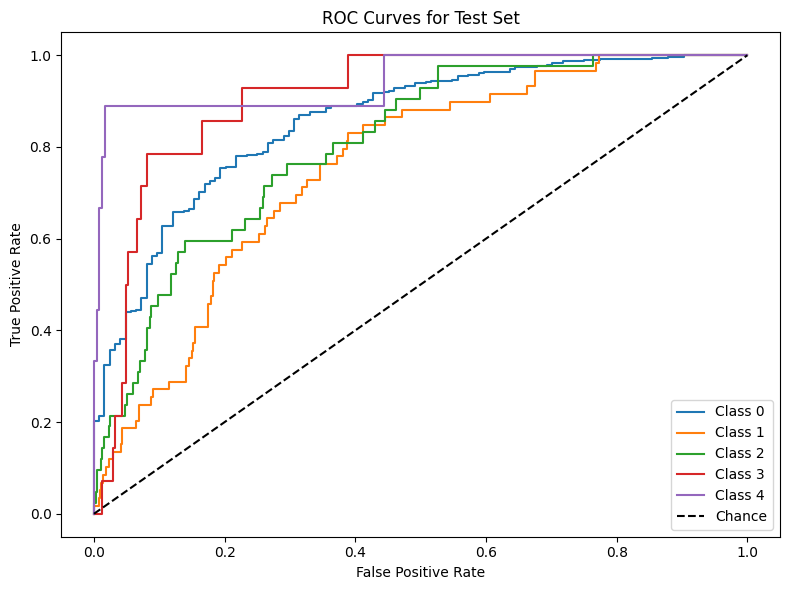


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       455
           1       0.59      0.25      0.35        52
           2       0.31      0.28      0.29        29
           3       0.00      0.00      0.00        10
           4       0.60      0.38      0.46         8

    accuracy                           0.84       554
   macro avg       0.48      0.37      0.41       554
weighted avg       0.80      0.84      0.81       554



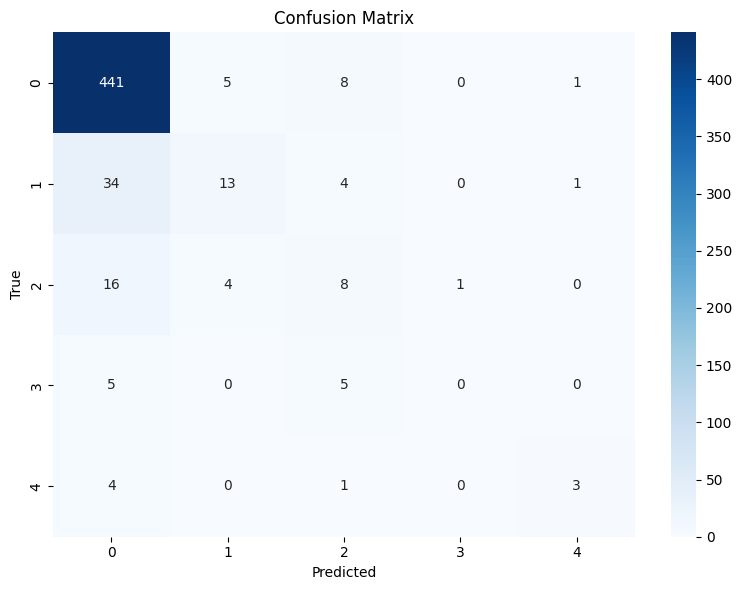


Test AUC (macro-average, OVR): 0.8345


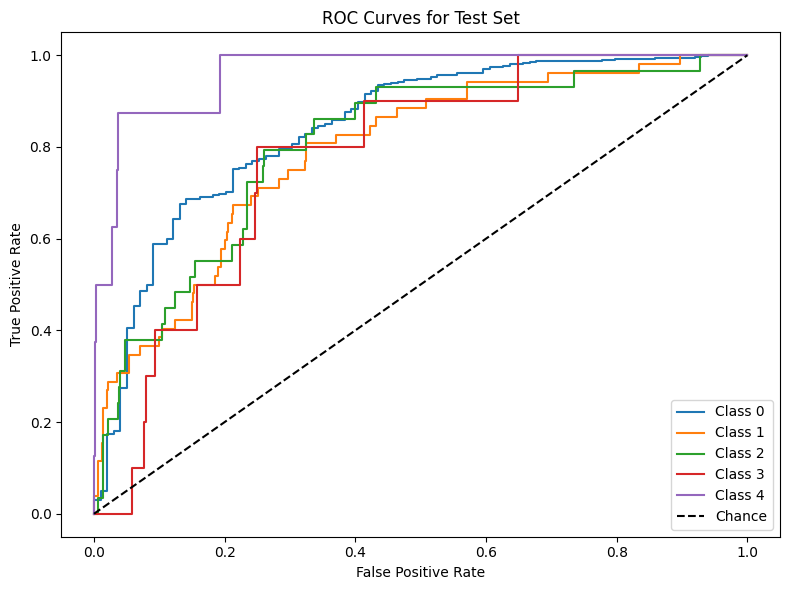


Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.96      0.93       395
           1       0.40      0.25      0.31        40
           2       0.32      0.33      0.33        24
           3       0.00      0.00      0.00        10
           4       1.00      0.12      0.22         8

    accuracy                           0.84       477
   macro avg       0.52      0.33      0.36       477
weighted avg       0.81      0.84      0.81       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


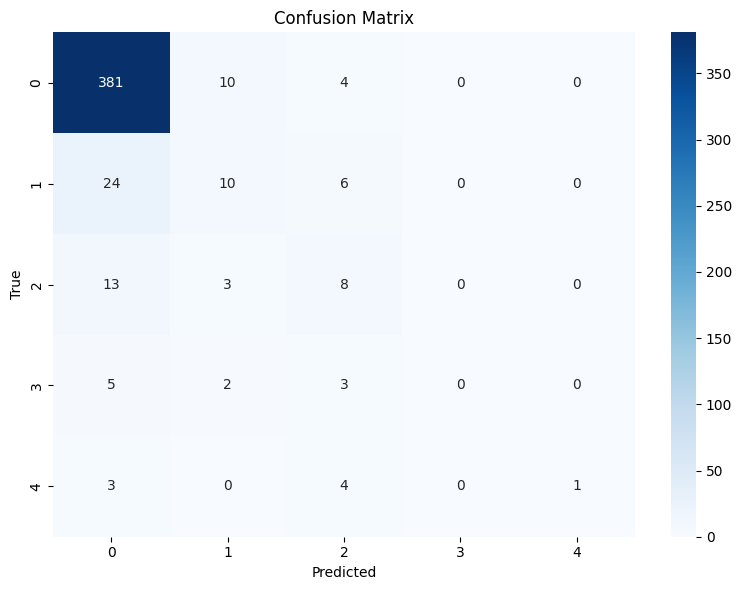


Test AUC (macro-average, OVR): 0.7800


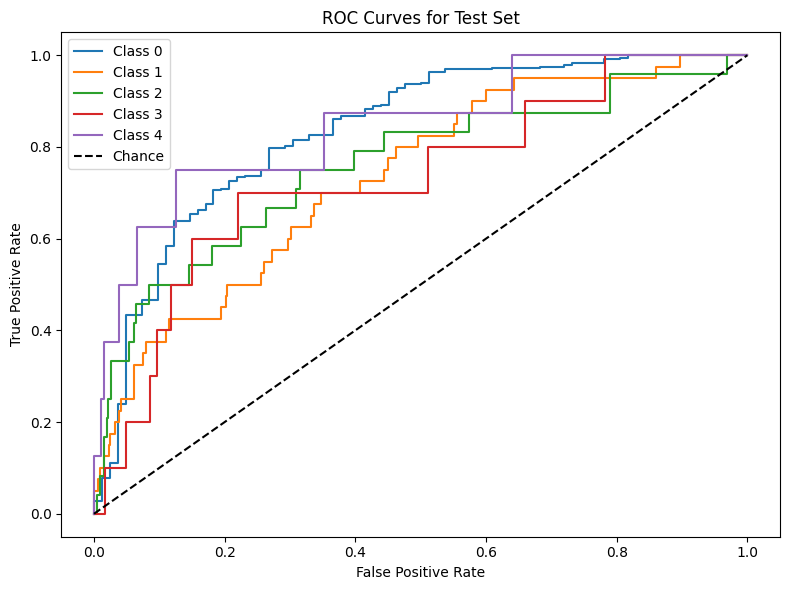

In [7]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/filtered-final-data/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)


# Sample


=== Training Phase 1 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

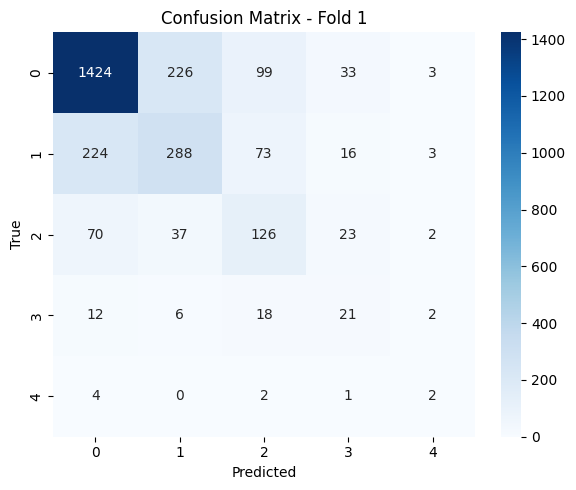

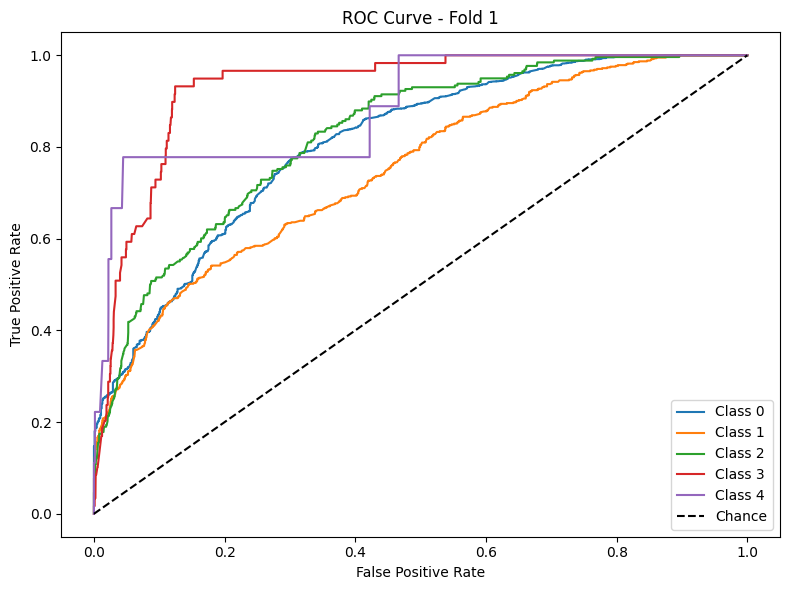

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7392
[LightGBM] [Info] Number of data points in the train set: 31580, number of used features: 32
[LightGBM] [Info] Start training from score -1.486671
[LightGBM] [Info] Start training from score -1.486671
[LightGBM] [Info] Start training from score -1.486671
[LightGBM] [Info] Start training from score -1.486671
[LightGBM] [Info] Start training from score -2.348593

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.77      0.80      1786
           1       0.48      0.49      0.48       603
           2       0.42      0.45      0.44       258
           3       0.23      0.49      0.31        59
           4       0.36      0.62      0.45         8

    accuracy       

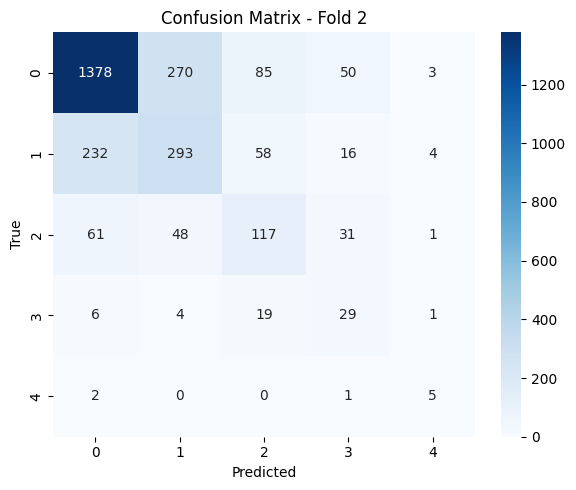

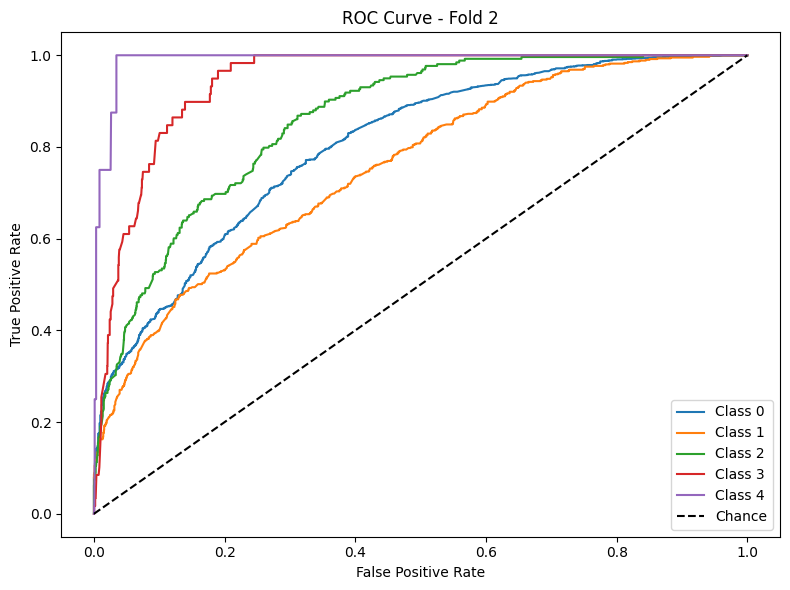

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7477
[LightGBM] [Info] Number of data points in the train set: 31580, number of used features: 32
[LightGBM] [Info] Start training from score -1.486671
[LightGBM] [Info] Start training from score -1.486671
[LightGBM] [Info] Start training from score -1.486671
[LightGBM] [Info] Start training from score -1.486671
[LightGBM] [Info] Start training from score -2.348593

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.77      0.79      1786
           1       0.49      0.49      0.49       603
           2       0.41      0.53      0.46       258
           3       0.29      0.44      0.35        59
           4       0.38      0.38      0.38         8

    accuracy       

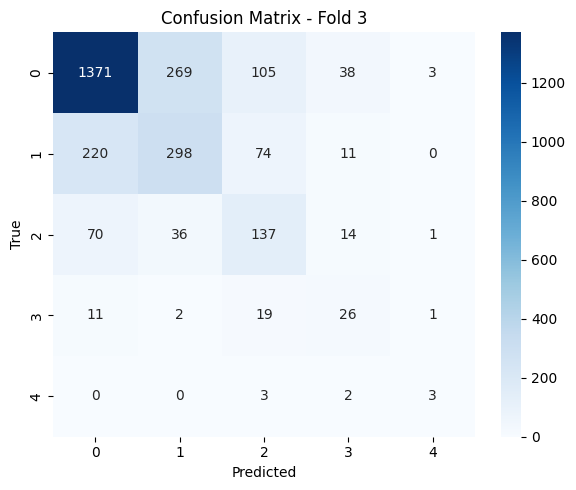

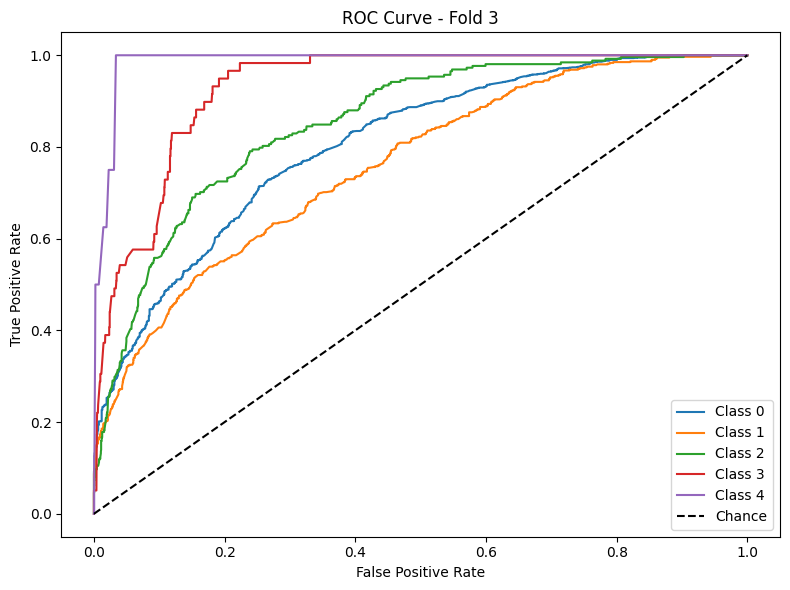

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7398
[LightGBM] [Info] Number of data points in the train set: 31584, number of used features: 32
[LightGBM] [Info] Start training from score -1.486658
[LightGBM] [Info] Start training from score -1.486658
[LightGBM] [Info] Start training from score -1.486658
[LightGBM] [Info] Start training from score -1.486658
[LightGBM] [Info] Start training from score -2.348719

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.81      1785
           1       0.50      0.52      0.51       603
           2       0.41      0.51      0.45       258
           3       0.20      0.27      0.23        59
           4       0.20      0.22      0.21         9

    accuracy       

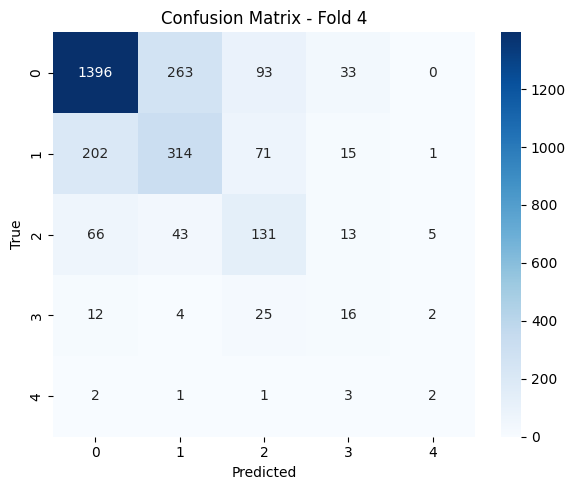

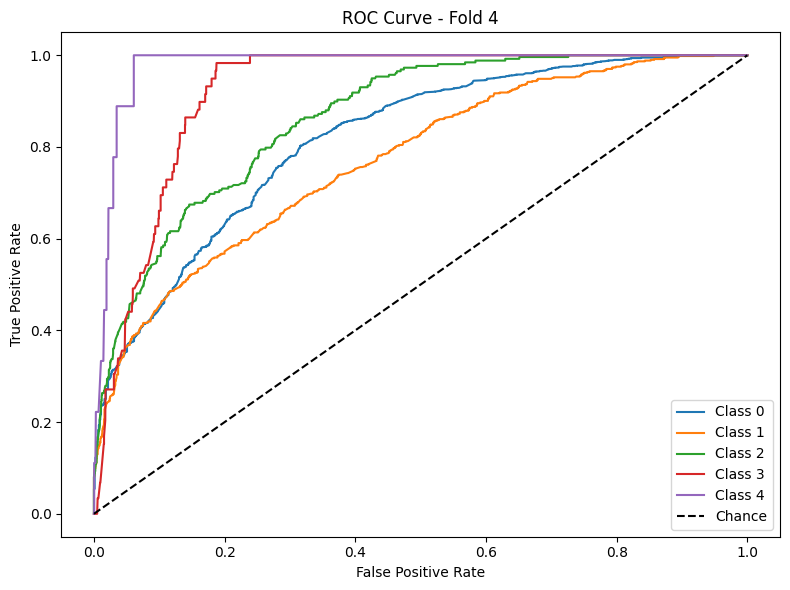

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7555
[LightGBM] [Info] Number of data points in the train set: 31584, number of used features: 32
[LightGBM] [Info] Start training from score -1.486658
[LightGBM] [Info] Start training from score -1.486658
[LightGBM] [Info] Start training from score -1.486658
[LightGBM] [Info] Start training from score -1.486658
[LightGBM] [Info] Start training from score -2.348719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 5 Classification Report:
               precision    recall  f1-score  

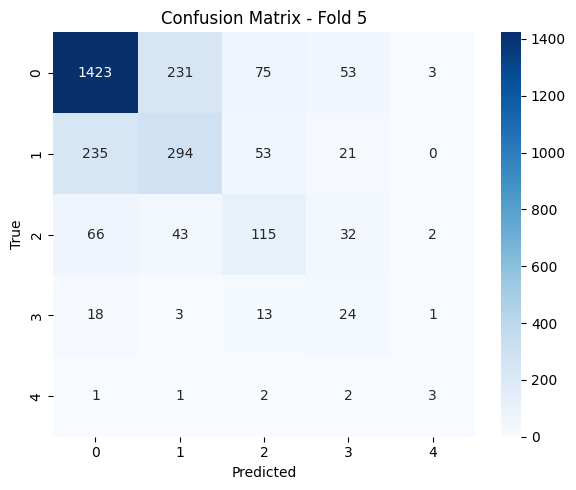

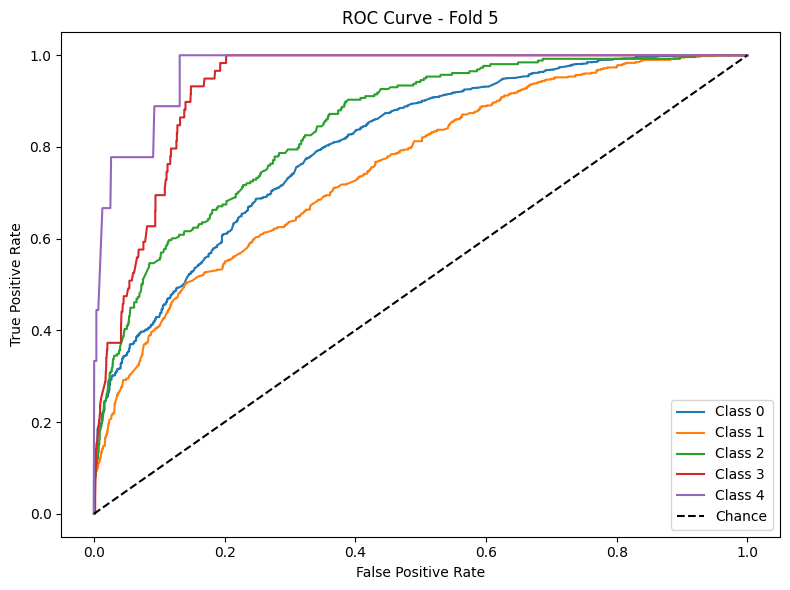


Average Accuracy: 0.6806
Average F1 Macro: 0.4681
Average AUC: 0.8619

Top Feature Importances:
remaining_time                 33794
school                         19417
total_words_phase1             12035
user_month                      8791
encoded_field_sum               5174
total_neutral1                  5097
video_count                     4482
user_time_since_last_course     3928
exercise_count                  3912
duration_days                   3437
dtype: int32

=== Training Phase 2 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7016
[LightGBM] [Info] Number of data points in the train set: 21056, number of used features: 32
[LightGBM] [Info] Start training from score -1.486728
[LightGBM] [Info] Start t

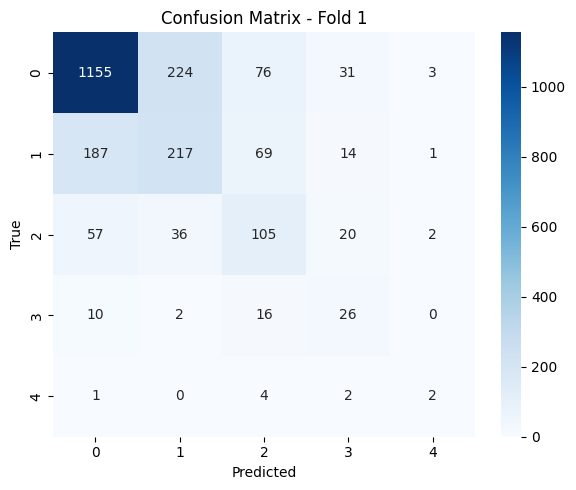

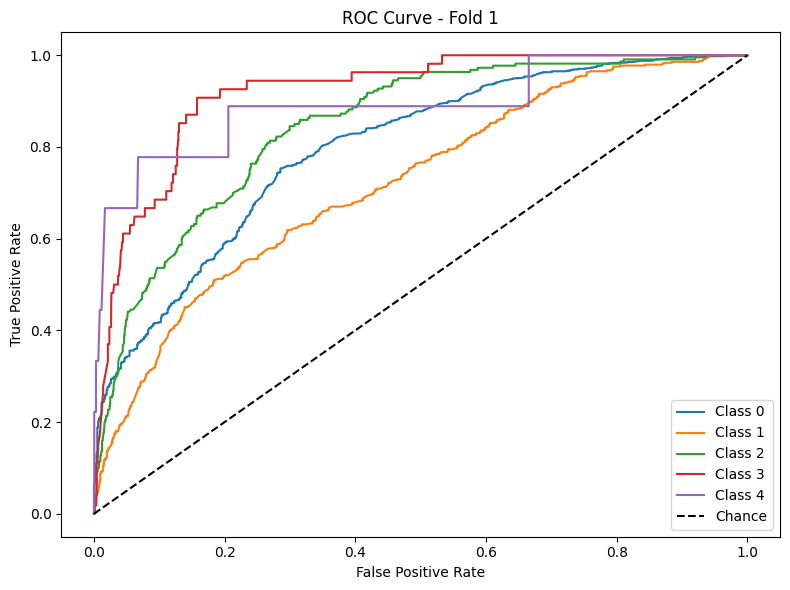

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10651
[LightGBM] [Info] Number of data points in the train set: 26346, number of used features: 48
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -2.347852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

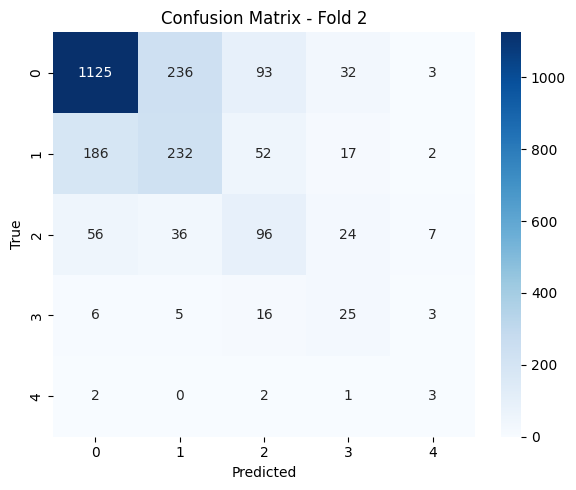

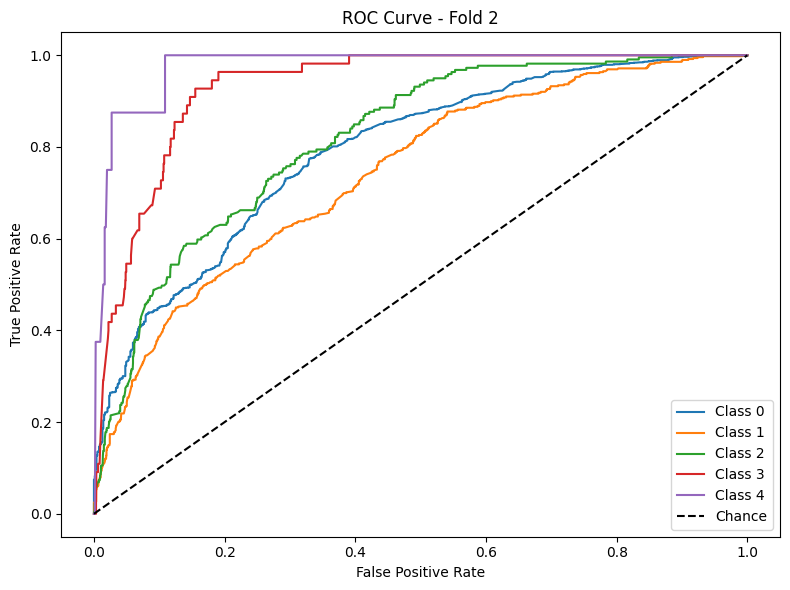

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10753
[LightGBM] [Info] Number of data points in the train set: 26346, number of used features: 48
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -2.347852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

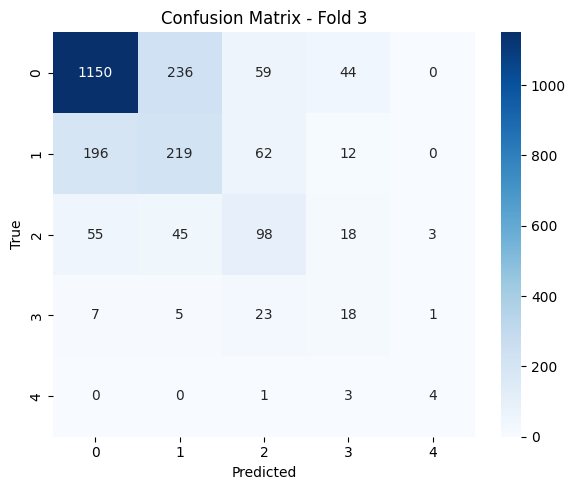

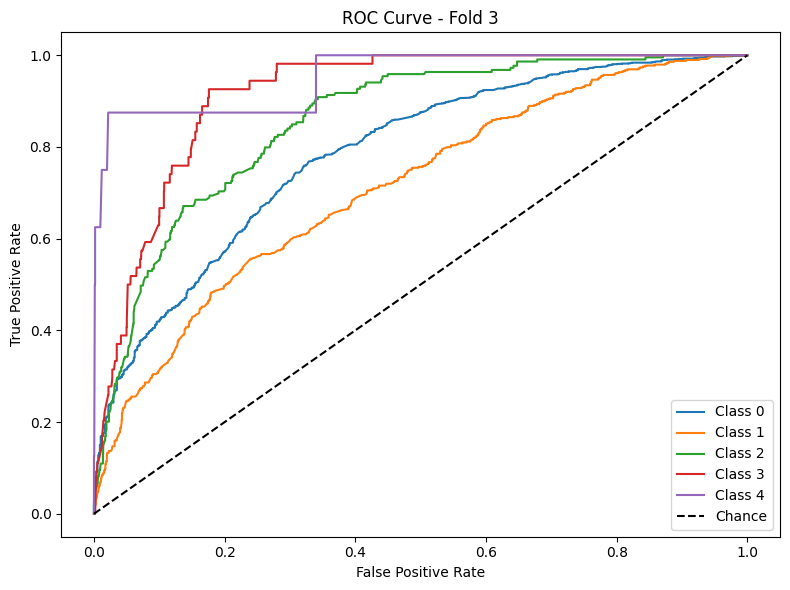

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10655
[LightGBM] [Info] Number of data points in the train set: 26346, number of used features: 48
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -1.486749
[LightGBM] [Info] Start training from score -2.347852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

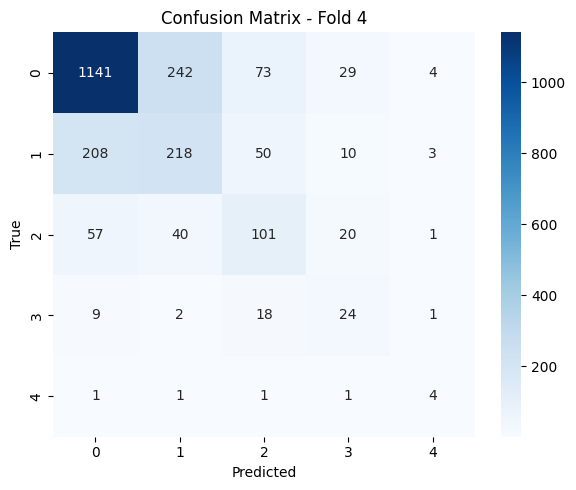

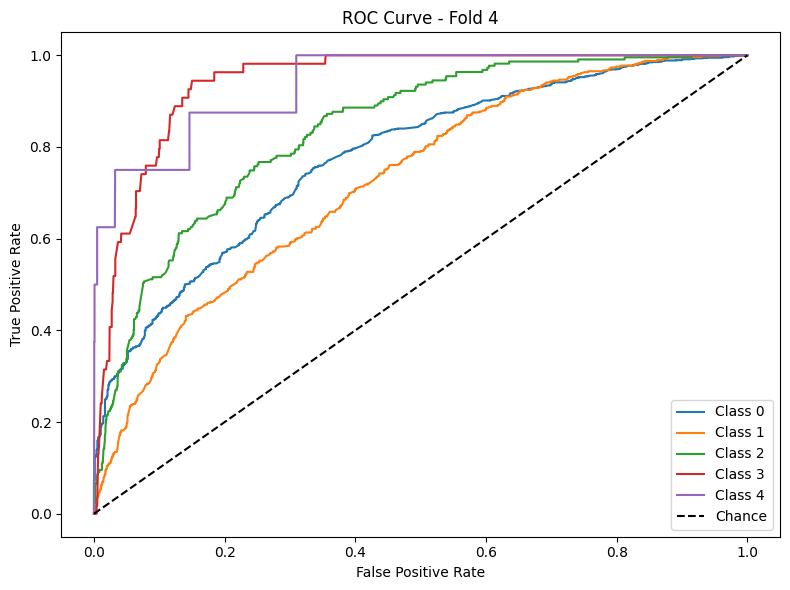

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10769
[LightGBM] [Info] Number of data points in the train set: 26342, number of used features: 48
[LightGBM] [Info] Start training from score -1.486766
[LightGBM] [Info] Start training from score -1.486766
[LightGBM] [Info] Start training from score -1.486766
[LightGBM] [Info] Start training from score -1.486766
[LightGBM] [Info] Start training from score -2.347700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

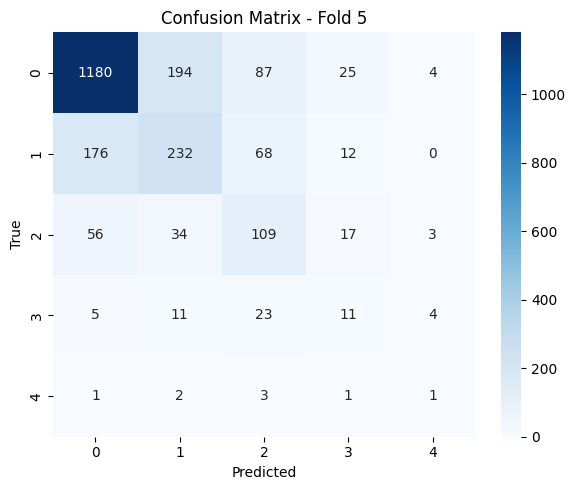

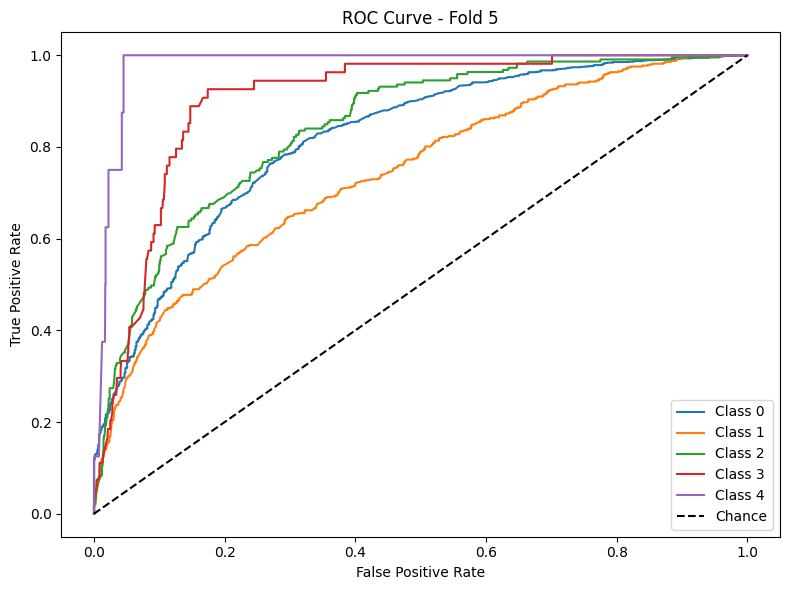


Average Accuracy: 0.6635
Average F1 Macro: 0.4507
Average AUC: 0.8461

Top Feature Importances:
remaining_time                 92309
school                         38509
total_words_phase1             18543
user_month                     10469
encoded_field_sum               7260
user_time_since_last_course     7250
video_count                     7083
total_words_phase2              6531
exercise_count                  6120
duration_days                   5507
dtype: int32

=== Training Phase 3 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

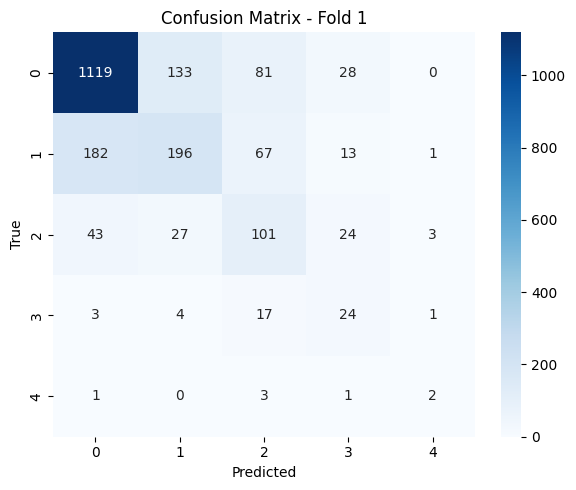

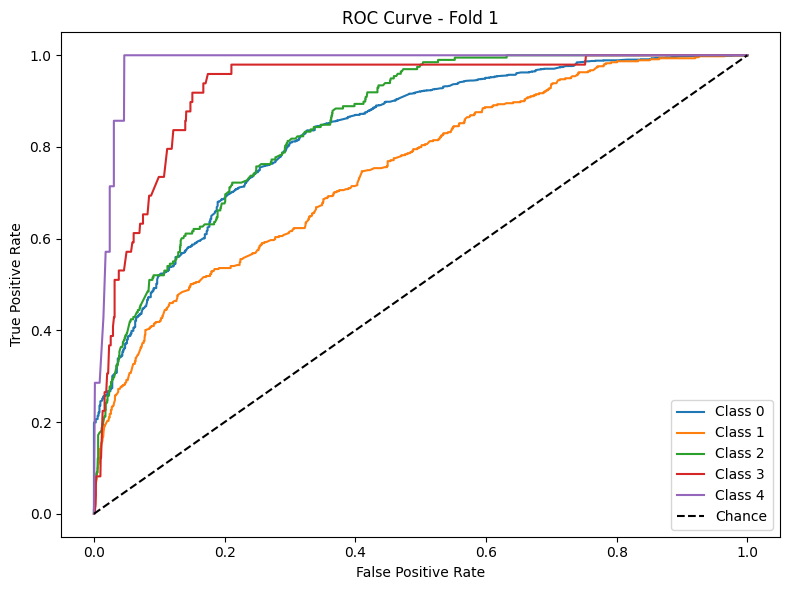

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13345
[LightGBM] [Info] Number of data points in the train set: 24063, number of used features: 64
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -2.348201

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.81      1360
           1       0.49      0.47      0.48       459
           2       0.41      0.49      0.45       198
           3       0.31      0.46      0.37        50
           4       0.00      0.00      0.00         7

    accuracy      

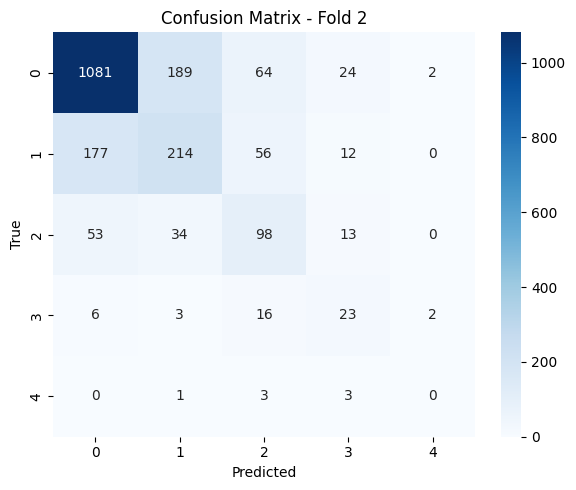

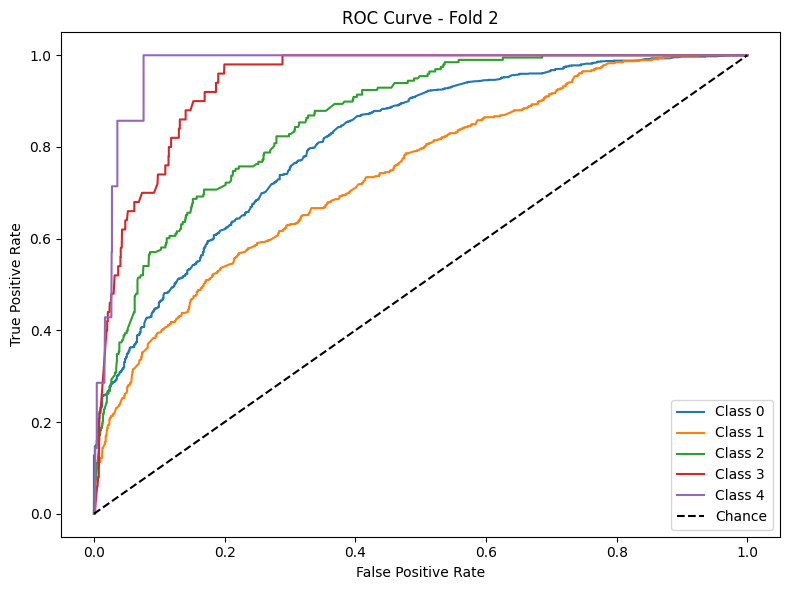

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12492
[LightGBM] [Info] Number of data points in the train set: 24063, number of used features: 63
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -2.348201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.80      0.81      1360
           1       0.47      0.45      0.46       459
           2       0.39      0.43      0.41       198
           3       0.25      0.44      0.32        5

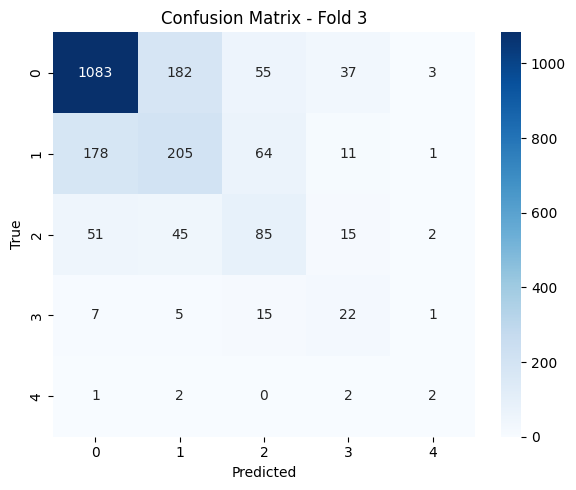

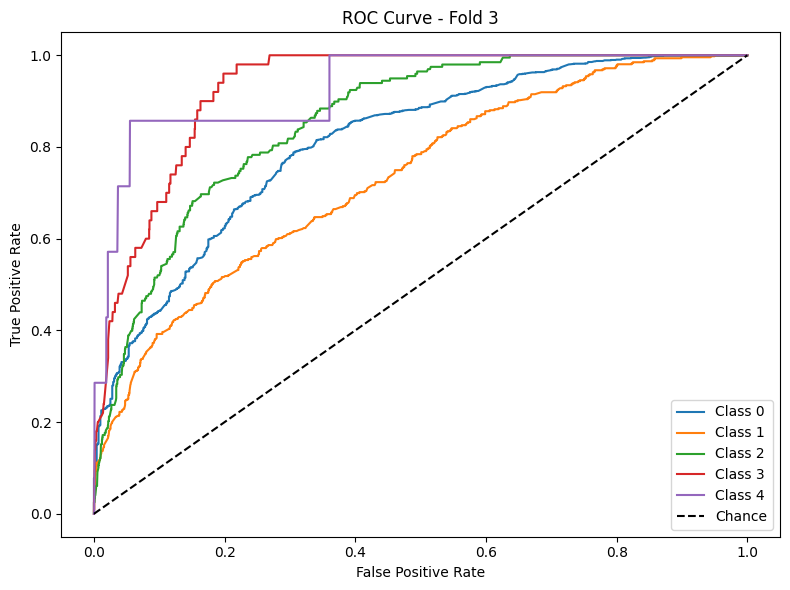

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12718
[LightGBM] [Info] Number of data points in the train set: 24063, number of used features: 64
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -2.348201

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.77      0.79      1360
           1       0.44      0.45      0.44       459
           2       0.43      0.48      0.45       198
           3       0.35      0.46      0.40        50
           4       0.15      0.29      0.20         7

    accuracy      

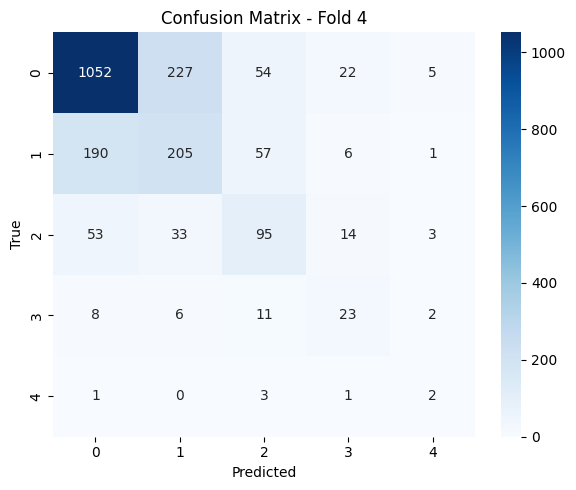

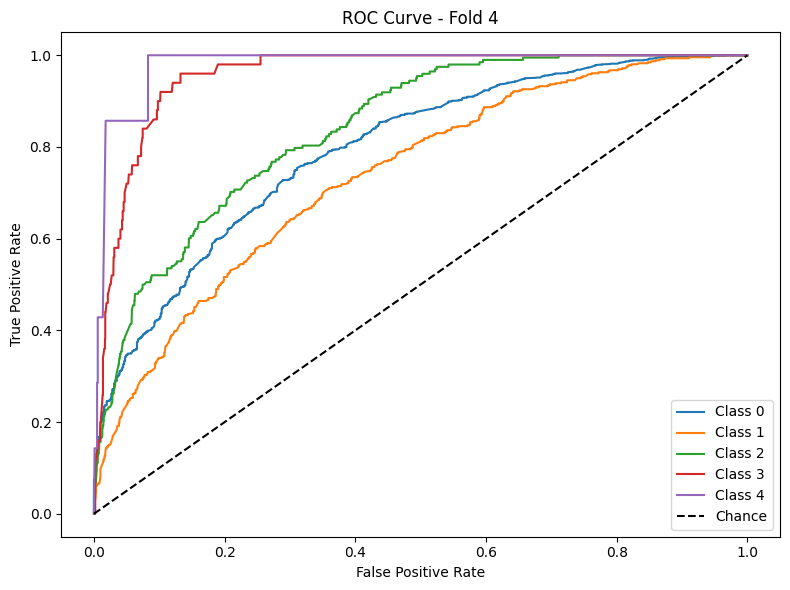

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13146
[LightGBM] [Info] Number of data points in the train set: 24063, number of used features: 64
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -1.486713
[LightGBM] [Info] Start training from score -2.348201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80      1360
           1       0.48      0.49      0.49       460
           2       0.42      0.47      0.45       197
           3       0.22      0.35      0.27        4

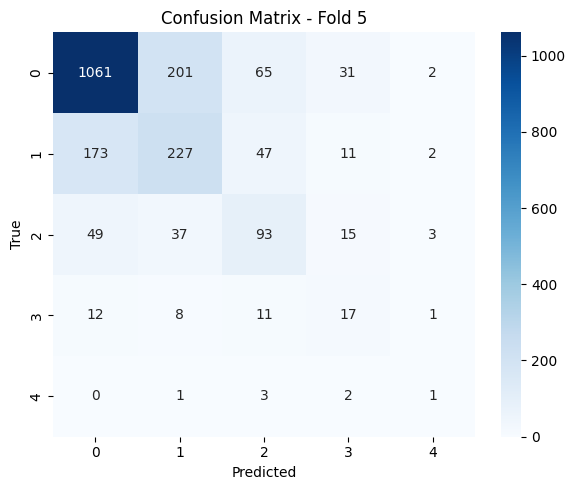

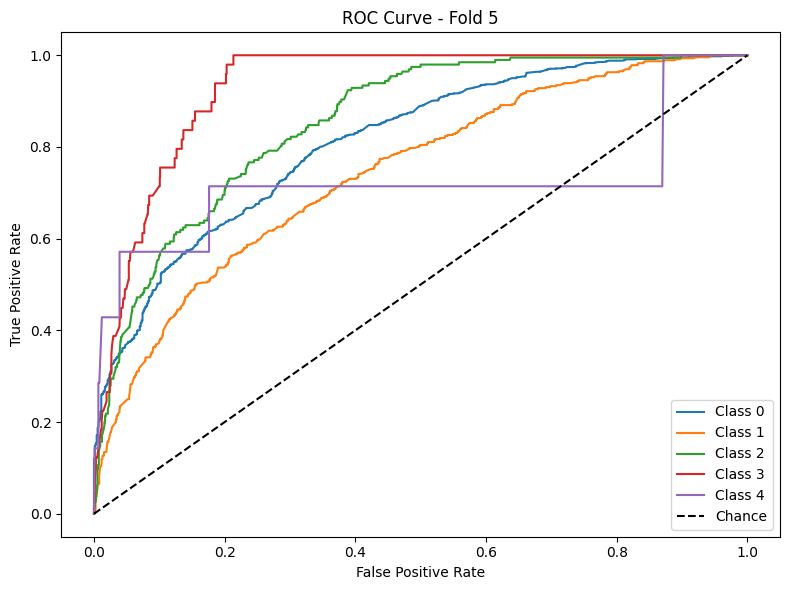


Average Accuracy: 0.6781
Average F1 Macro: 0.4450
Average AUC: 0.8514

Top Feature Importances:
remaining_time        24773
school                11509
total_words_phase1     7919
user_month             5241
encoded_field_sum      4237
video_count            3466
exercise_count         3436
total_neutral1         3209
duration_days          2899
total_words_phase3     2875
dtype: int32

=== Training Phase 4 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

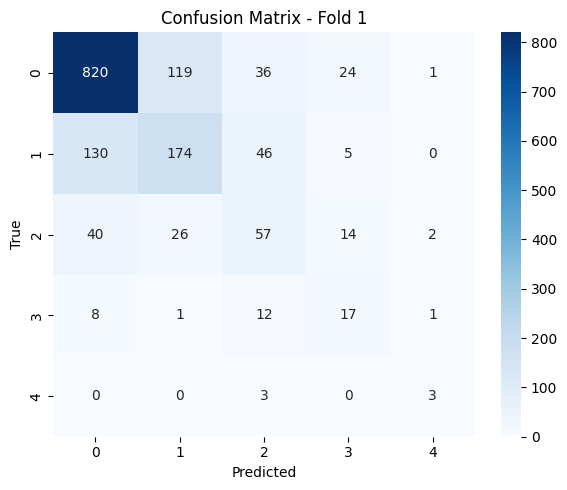

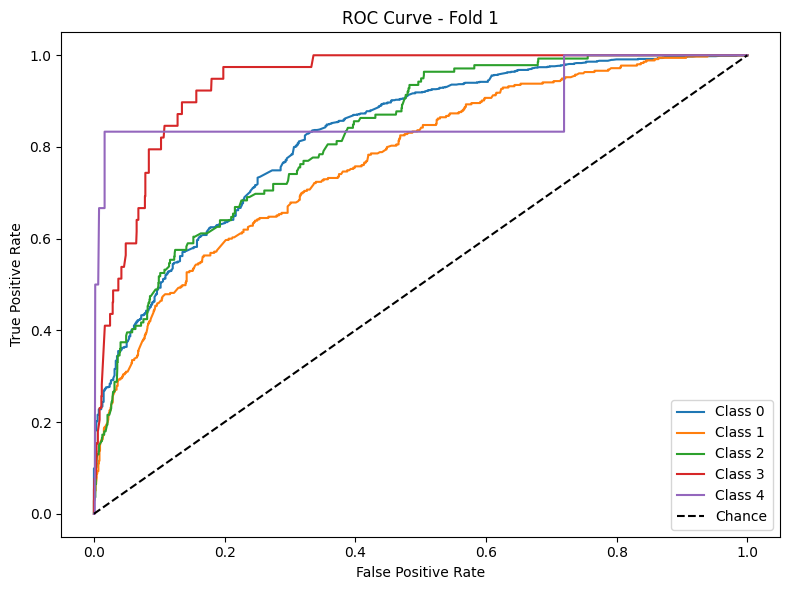

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15228
[LightGBM] [Info] Number of data points in the train set: 17679, number of used features: 79
[LightGBM] [Info] Start training from score -1.486833
[LightGBM] [Info] Start training from score -1.486833
[LightGBM] [Info] Start training from score -1.486833
[LightGBM] [Info] Start training from score -1.486833
[LightGBM] [Info] Start training from score -2.347057

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.79      0.80      1000
           1       0.50      0.46      0.48       355
           2       0.51      0.52      0.52       139
           3       0.27      0.45      0.34        40
           4       0.00      0.00      0.00         5

    accuracy      

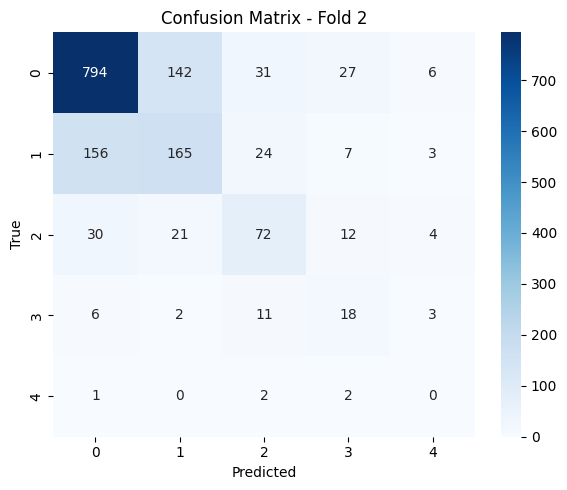

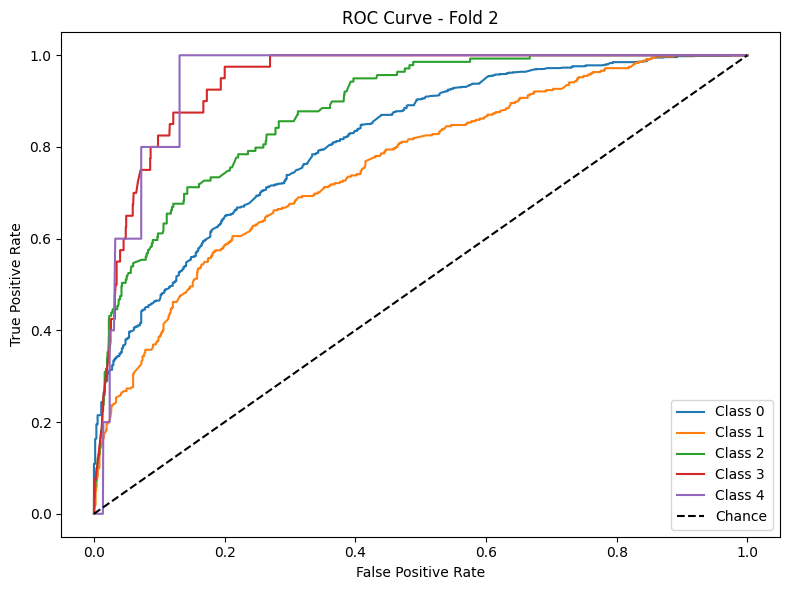

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15520
[LightGBM] [Info] Number of data points in the train set: 17683, number of used features: 79
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -2.347284

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82       999
           1       0.55      0.53      0.54       355
           2       0.49      0.49      0.49       139
           3       0.25      0.38      0.30        40
           4       0.00      0.00      0.00         6

    accuracy      

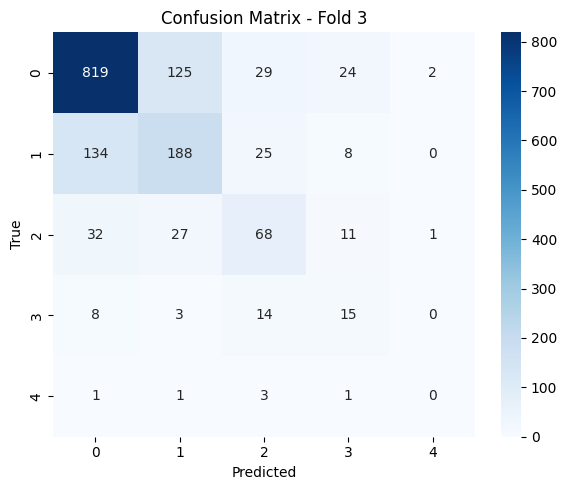

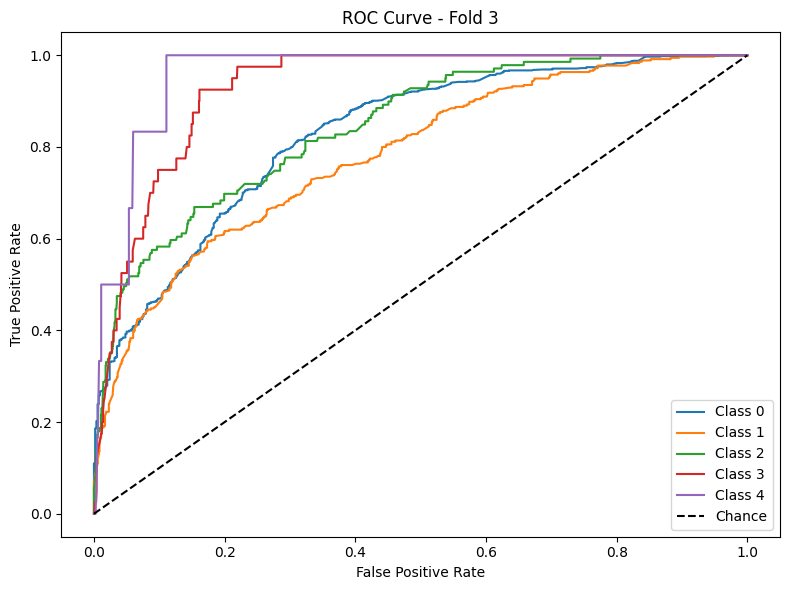

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15582
[LightGBM] [Info] Number of data points in the train set: 17683, number of used features: 79
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -2.347284

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.82       999
           1       0.51      0.44      0.47       356
           2       0.48      0.49      0.49       138
           3       0.27      0.44      0.34        39
           4       0.24      0.67      0.35         6

    accuracy      

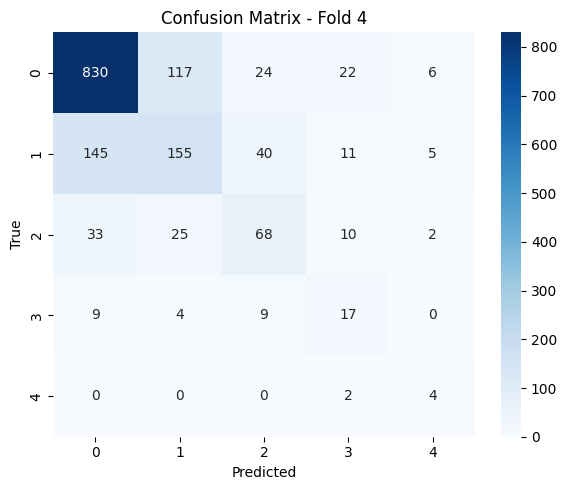

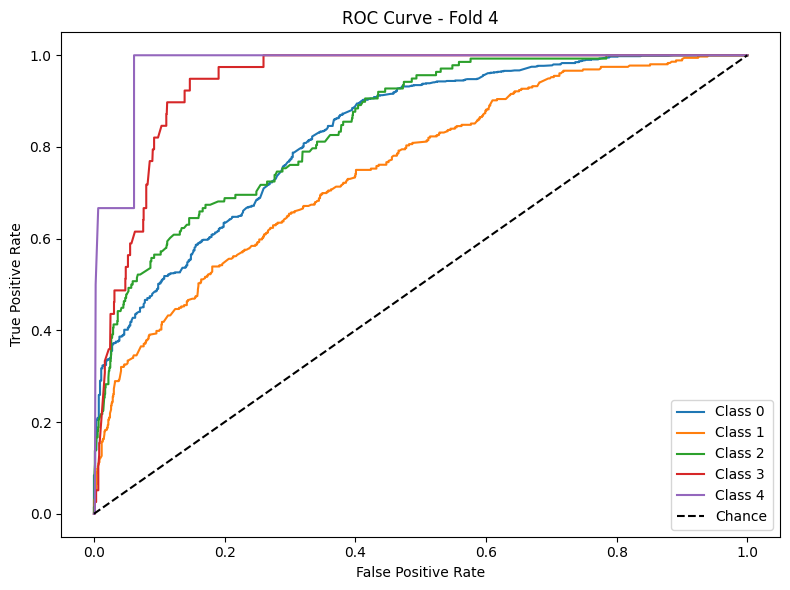

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12840
[LightGBM] [Info] Number of data points in the train set: 17683, number of used features: 79
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -1.486809
[LightGBM] [Info] Start training from score -2.347284

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82       999
           1       0.52      0.52      0.52       356
           2       0.43      0.44      0.44       138
           3       0.33      0.51      0.40        39
           4       0.00      0.00      0.00         6

    accuracy      

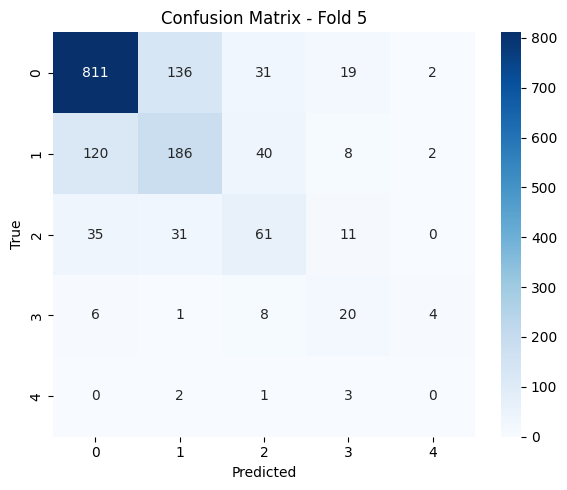

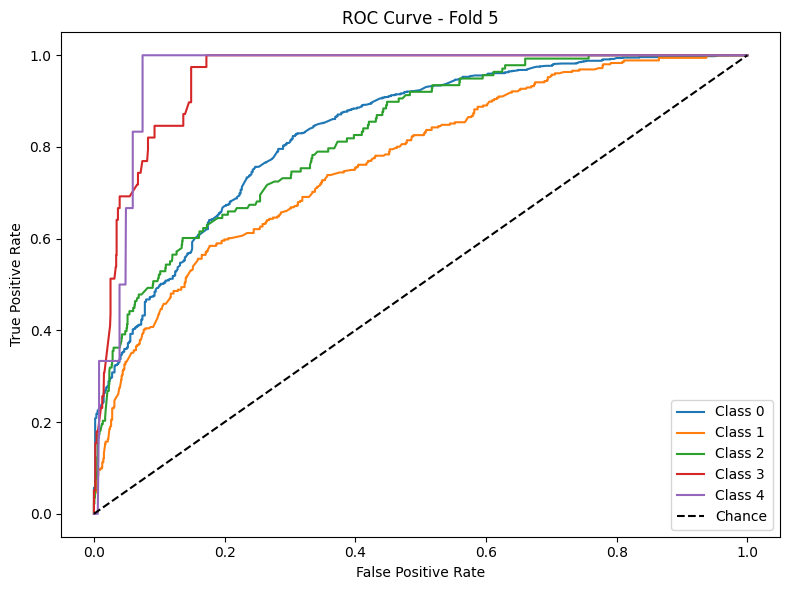


Average Accuracy: 0.6970
Average F1 Macro: 0.4588
Average AUC: 0.8642

Top Feature Importances:
remaining_time            5454
school                    3327
total_words_phase1        1563
total_words_phase4        1206
encoded_field_sum         1185
user_past_course_count    1086
total_neutral1            1023
exercise_count            1021
user_month                 986
duration_days              871
dtype: int32


In [8]:
phase_paths = [f"/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = True
    model, scaler, best_fold, metrics = train_phase(phase_path, param_dist, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics



Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       568
           1       0.36      0.33      0.35        63
           2       0.34      0.23      0.28        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.81       698
   macro avg       0.32      0.30      0.31       698
weighted avg       0.77      0.81      0.79       698



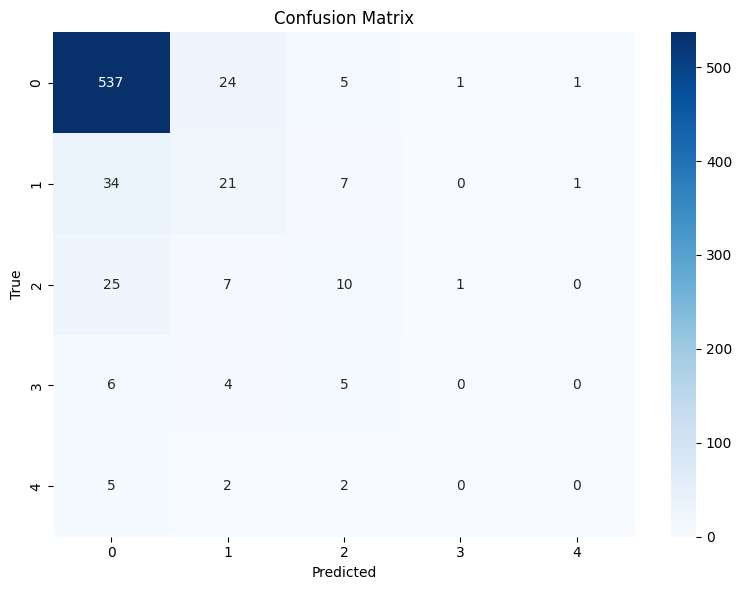


Test AUC (macro-average, OVR): 0.8577


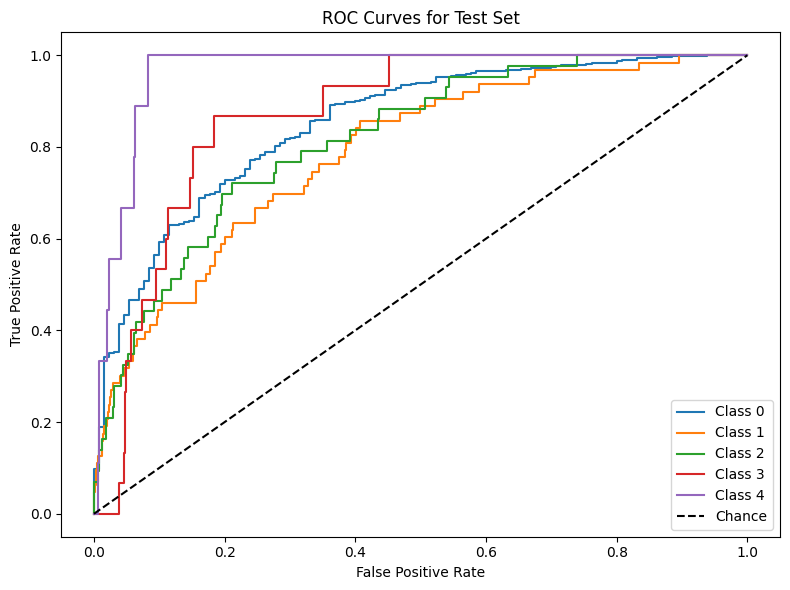


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       544
           1       0.21      0.20      0.21        59
           2       0.38      0.19      0.25        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.79       668
   macro avg       0.29      0.27      0.27       668
weighted avg       0.75      0.79      0.77       668



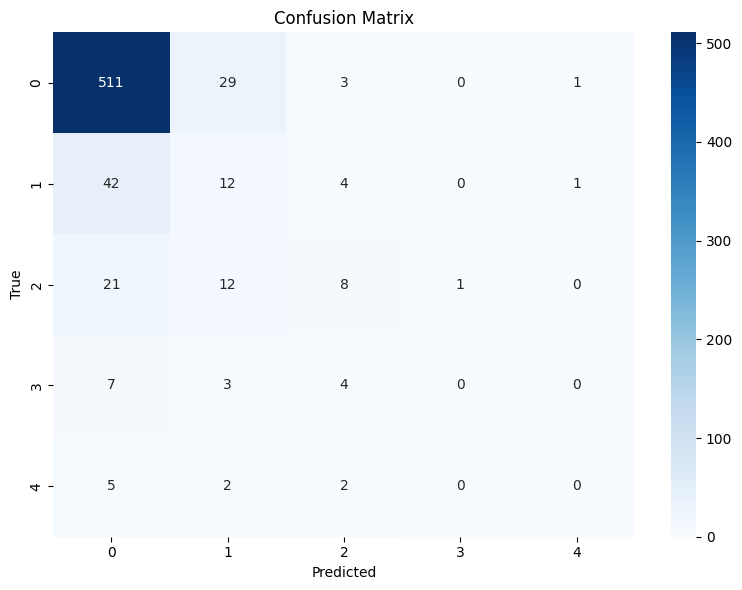


Test AUC (macro-average, OVR): 0.8452


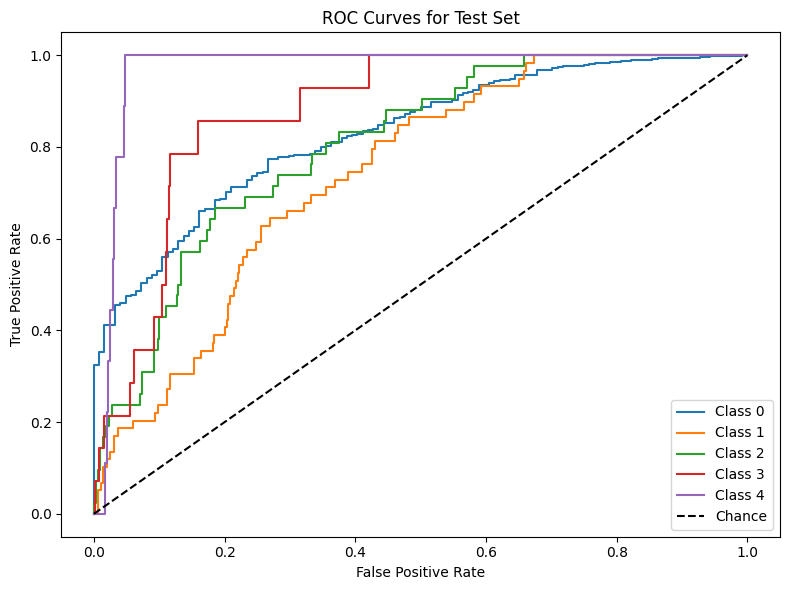


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       455
           1       0.36      0.33      0.34        52
           2       0.25      0.14      0.18        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.81       554
   macro avg       0.30      0.28      0.29       554
weighted avg       0.77      0.81      0.79       554



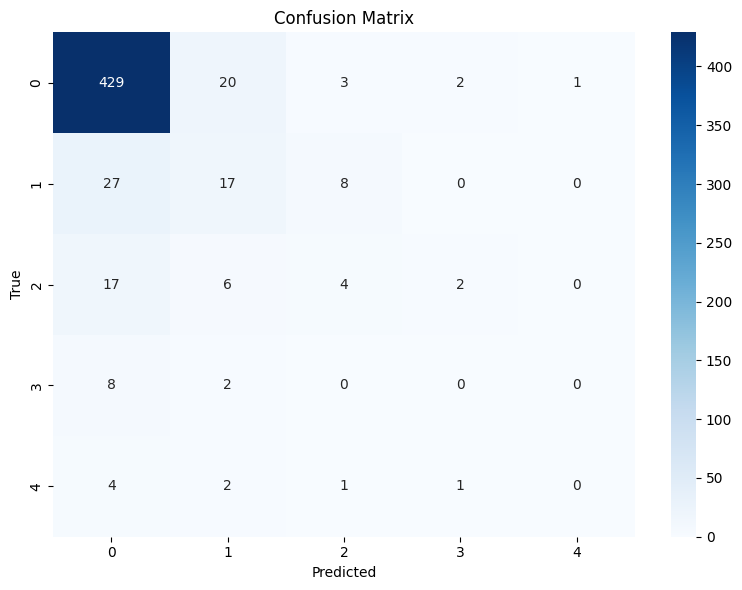


Test AUC (macro-average, OVR): 0.8209


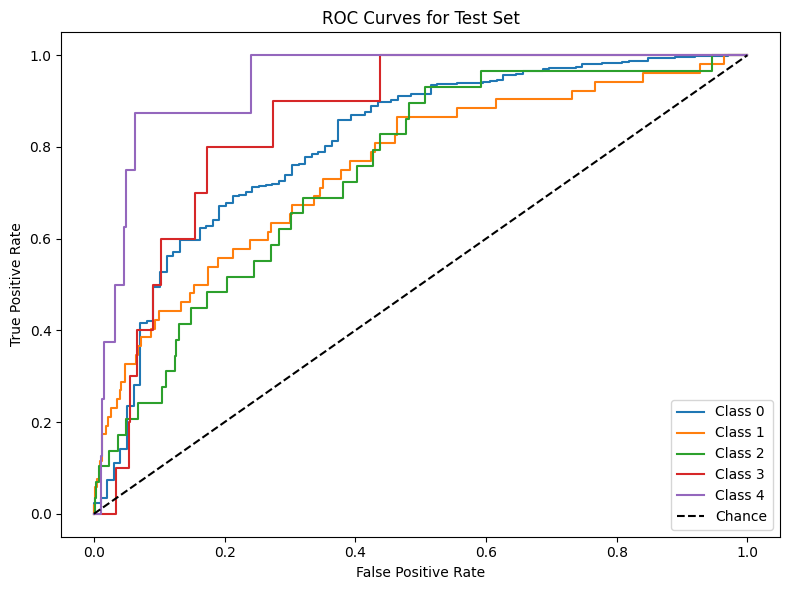


Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       395
           1       0.27      0.30      0.28        40
           2       0.18      0.29      0.22        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.78       477
   macro avg       0.27      0.30      0.28       477
weighted avg       0.78      0.78      0.78       477



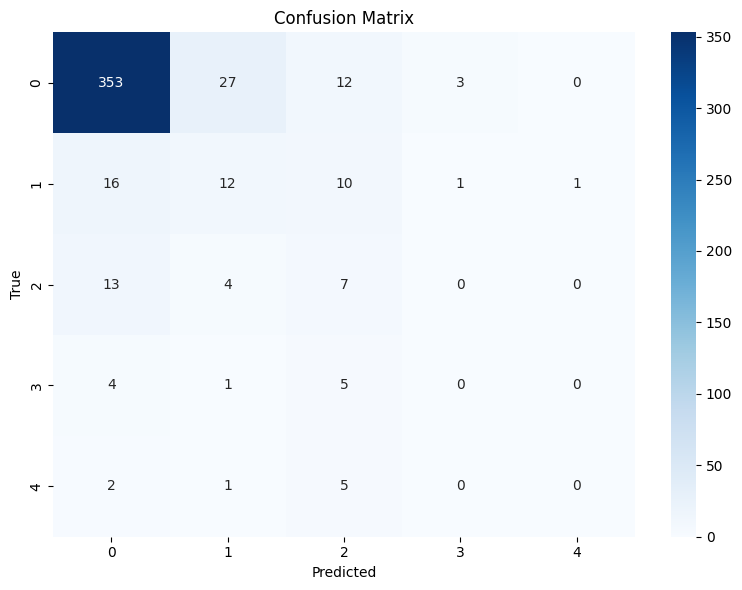


Test AUC (macro-average, OVR): 0.7562


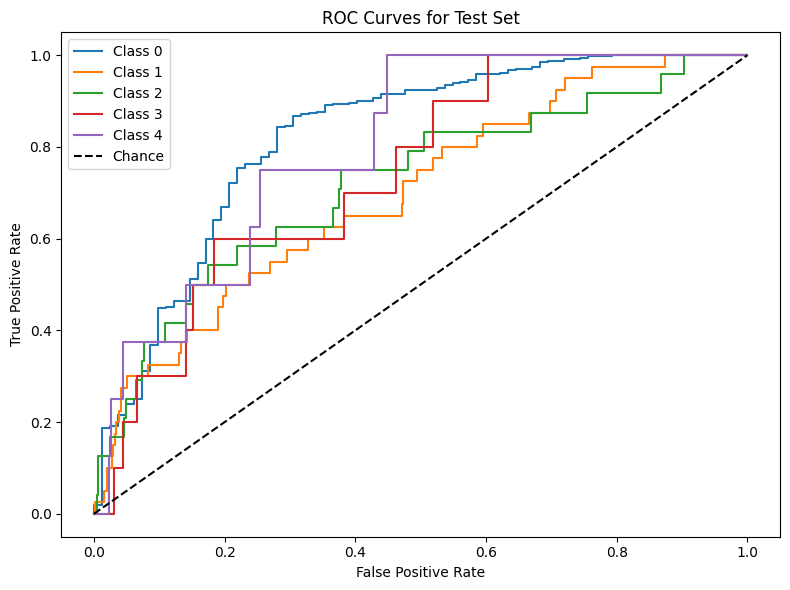

In [9]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/filtered-final-data/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)
